<a href="https://colab.research.google.com/github/LoSgu8/Failure-Management/blob/main/FailureManagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 7.9 MB/s 


In [ ]:
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 9.7 MB/s 
     |████████████████████████████████| 199 kB 45.1 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.losses import BinaryCrossentropy


# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# Performance Analysis
import sklearn.metrics as mt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

#Features reduction
from sklearn.feature_selection import SelectFromModel

# SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## General Purpose Functions

### Dataset Load

In [ ]:
def load_split_scale_dataset(dataset):
  '''
  This function splits the given dataset (pd.DataFrame) in two np.arrays:
  - X containing all the features
  - y containing only the groundtruth
  Assuming that the groundtruth is the last column of the DataFrame.
  Then, it splits the dataset and scale it (fit only on train)

  :param dataset: the entire dataset
  :return X_train: the features columns
  :return y: the groundtruth column
  '''

  X = dataset.iloc[:,0:-1].to_numpy()
  y = dataset.iloc[:,-1].to_numpy()

  #splitting
  test_percentage = 0.3

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage,
                                                      random_state=42, stratify=y)

  scaler = StandardScaler()
  # Fit the scaler only on the train set
  scaler.fit(X_train)

  # Transform test and train set with the train fitted scaler
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
    
  return X_train, X_test, y_train, y_test

### Performance Analysis

In [ ]:
def visualize_perfomance(y_pred, y_true, classes, imageName):
  '''
  This function, given predicted labels, true labels and a list of possible labels,
  print accuracy, precision, f1 and recall metrics and it plots the Confusion Matrix
  '''
  accuracy_perf = mt.accuracy_score(y_true, y_pred)
  precision_perf = mt.precision_score(y_true, y_pred, average='weighted')
  f1_perf = mt.f1_score(y_true, y_pred, average='weighted')
  recall_perf = mt.recall_score(y_true, y_pred, average='weighted')

  print('Accuracy: {}'.format(accuracy_perf))
  print('Precision: {}'.format(precision_perf))
  print('F1: {}'.format(f1_perf))
  print('Recall: {}'.format(recall_perf))

  cm = confusion_matrix(y_true, y_pred, labels=classes, normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot()

  disp.figure_.savefig(str(imageName)+".png")
  
  return accuracy_perf, precision_perf, f1_perf, recall_perf

## Data Loading and Analysis

### Data Loading

In [ ]:
raw_data = pd.read_csv('Labelled_Multiclass.csv')

In [ ]:
columns = raw_data.columns.to_numpy()
data = raw_data.drop(columns=columns[:4])
data

,eqtype,acmLowerMode,freqband,bandwidth,acmEngine,esN-2,sesN-2,txMaxAN-2,txminAN-2,rxmaxAN-2,...,rxminAN,txMaxBN,txminBN,rxmaxBN,rxminBN,lowthr,ptx,RxNominal,Thr_min,label
0,19,2,18,28,1,0.0,0.0,18.0,18.0,-49.0,...,-97.0,22.0,18.0,-52.0,-96.0,-85.0,23.0,-44,-86,0.0
1,19,2,18,28,1,0.0,0.0,18.0,18.0,-49.0,...,-96.0,22.0,18.0,-52.0,-93.0,-85.0,23.0,-44,-86,0.0
2,19,2,18,56,1,0.0,0.0,18.0,18.0,-45.0,...,-91.0,22.0,18.0,-53.0,-89.0,-82.5,23.0,-52,-84,0.0
3,19,2,18,56,1,0.0,0.0,18.0,18.0,-45.0,...,-95.0,22.0,22.0,-78.0,-94.0,-82.5,23.0,-52,-84,0.0
4,19,2,18,56,1,0.0,0.0,18.0,18.0,-45.0,...,-93.0,22.0,18.0,-47.0,-90.0,-82.5,23.0,-52,-84,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,19,2,13,28,1,0.0,0.0,18.0,18.0,-58.0,...,-97.0,22.0,18.0,-54.0,-96.0,-85.5,28.0,-49,-87,1.0
2509,19,9,18,56,0,0.0,0.0,18.0,18.0,-40.0,...,-87.0,18.0,18.0,-49.0,-83.0,-64.5,18.0,-37,-84,0.0
2510,19,9,18,56,0,0.0,0.0,18.0,18.0,-39.0,...,-86.0,18.0,18.0,-47.0,-82.0,-64.5,18.0,-37,-84,0.0
2511,19,2,18,56,1,0.0,0.0,17.0,17.0,-55.0,...,-71.0,17.0,17.0,-48.0,-93.0,-82.5,23.0,-56,-84,0.0


### Correlation

,eqtype,acmLowerMode,bandwidth,acmEngine,esN-2,sesN-2,txMaxAN-2,txminAN-2,rxmaxAN-2,rxminAN-2,txMaxBN-2,txminBN-2,rxmaxBN-2,rxminBN-2,esN-1,sesN-1,txMaxAN-1,txminAN-1,rxmaxAN-1,rxminAN-1,txMaxBN-1,txminBN-1,rxmaxBN-1,rxminBN-1,esN,sesN,txMaxAN,txminAN,rxmaxAN,rxminAN,txMaxBN,txminBN,rxmaxBN,rxminBN,lowthr,ptx,RxNominal,Thr_min,label
eqtype,1.000000,-0.024754,0.135120,0.318775,-0.104378,0.050019,0.079076,0.080859,-0.080129,0.000827,0.249923,0.202392,0.089484,0.161102,-0.110292,0.052243,0.063345,0.067223,-0.073537,0.027740,0.246600,0.174472,0.101584,0.183860,-0.131468,0.048185,0.063175,0.076507,-0.075922,0.087898,0.244969,0.142420,0.105751,0.238831,-0.114593,0.416249,0.046417,0.101797,0.371430
acmLowerMode,-0.024754,1.000000,0.118438,-0.865423,0.018757,0.043707,0.049698,0.055704,0.119597,0.072317,0.078819,0.143277,0.075586,0.007082,0.041348,0.048588,0.036077,0.055861,0.119762,0.057080,0.050797,0.121196,0.081731,-0.021280,0.087186,0.054421,0.029917,0.027703,0.104113,0.021752,0.007525,0.089777,0.084002,-0.074183,0.897397,-0.218509,0.111221,-0.015594,-0.154103
bandwidth,0.135120,0.118438,1.000000,-0.188217,-0.033928,-0.021496,-0.087644,-0.121906,0.114566,0.056977,-0.239423,-0.262215,0.111016,0.036953,-0.025592,-0.010879,-0.070546,-0.126068,0.100111,0.028016,-0.227876,-0.244305,0.095143,-0.002974,-0.014922,-0.015235,-0.049809,-0.114924,0.094754,-0.006907,-0.198032,-0.138537,0.093405,-0.051454,0.439262,-0.371121,0.137301,0.865294,-0.268931
acmEngine,0.318775,-0.865423,-0.188217,1.000000,-0.001302,0.043052,-0.029424,-0.017652,-0.187152,-0.099769,-0.004766,-0.065069,-0.065484,0.051631,-0.012475,0.045632,-0.025053,-0.021609,-0.180218,-0.067557,0.013705,-0.043949,-0.062556,0.091734,-0.056278,0.043788,-0.022379,0.008734,-0.158166,-0.022061,0.043740,-0.027746,-0.055562,0.170153,-0.834520,0.324539,-0.004475,-0.038062,0.288286
esN-2,-0.104378,0.018757,-0.033928,-0.001302,1.000000,0.638811,0.076976,-0.010205,0.038435,-0.002206,0.105564,0.021077,0.022583,-0.026799,0.775974,0.544298,0.070440,-0.020322,0.045855,0.031667,0.090009,0.021502,0.033551,0.000375,0.678199,0.531814,0.064544,0.004115,0.048685,0.079831,0.076632,0.033863,0.042722,0.050049,-0.011042,0.027092,0.246659,-0.102976,-0.097348
sesN-2,0.050019,0.043707,-0.021496,0.043052,0.638811,1.000000,0.072009,0.009230,0.086529,0.036270,0.111048,0.044536,0.077737,0.019807,0.534910,0.836047,0.066307,0.013616,0.091374,0.060854,0.105073,0.050777,0.082831,0.039778,0.474643,0.779389,0.062861,0.028920,0.095938,0.102609,0.096567,0.038236,0.092290,0.080054,0.015776,0.089730,0.615952,-0.057621,-0.049045
txMaxAN-2,0.079076,0.049698,-0.087644,-0.029424,0.076976,0.072009,1.000000,0.741857,-0.000079,-0.034097,0.361407,0.250654,0.134157,0.133498,0.072136,0.067458,0.950257,0.720169,0.008240,-0.015051,0.362285,0.227635,0.130372,0.131687,0.061346,0.065367,0.812276,0.541515,0.009630,-0.014141,0.364247,0.138900,0.099686,0.131538,-0.060661,0.311469,-0.029338,-0.225112,0.050961
txminAN-2,0.080859,0.055704,-0.121906,-0.017652,-0.010205,0.009230,0.741857,1.000000,-0.012708,-0.007734,0.276379,0.243140,0.089613,0.152242,0.018755,0.019000,0.707733,0.592523,-0.000810,-0.007688,0.280504,0.204789,0.091125,0.122017,0.015180,0.016501,0.617342,0.589974,-0.019126,-0.028144,0.285724,0.122519,0.064144,0.124583,-0.045818,0.253828,-0.013936,-0.210381,0.036038
rxmaxAN-2,-0.080129,0.119597,0.114566,-0.187152,0.038435,0.086529,-0.000079,-0.012708,1.000000,0.916265,0.056275,0.023258,0.771096,0.614069,0.059451,0.100289,0.013706,-0.008182,0.961208,0.822495,0.057283,-0.002178,0.770531,0.543049,0.087319,0.124776,0.027809,-0.027972,0.903777,0.694376,0.073609,-0.006639,0.749175,0.454872,0.072233,0.048653,0.077577,-0.000584,0.016111
rxminAN-2,0.000827,0.072317,0.056977,-0.099769,-0.002206,0.036270,-0.034097,-0.007734,0.916265,1.000000,0.028225,0.064953,0.679474,0.647727,0.021125,0.054307,-0.018118,-0.018861,0.911094,0.894472,0.032926,0.016918,0.704623,0.568550,0.052841,0.083178,-0.000347,-0.035584,0.844914,0.762371,0.052702,0.018823,0.681060,

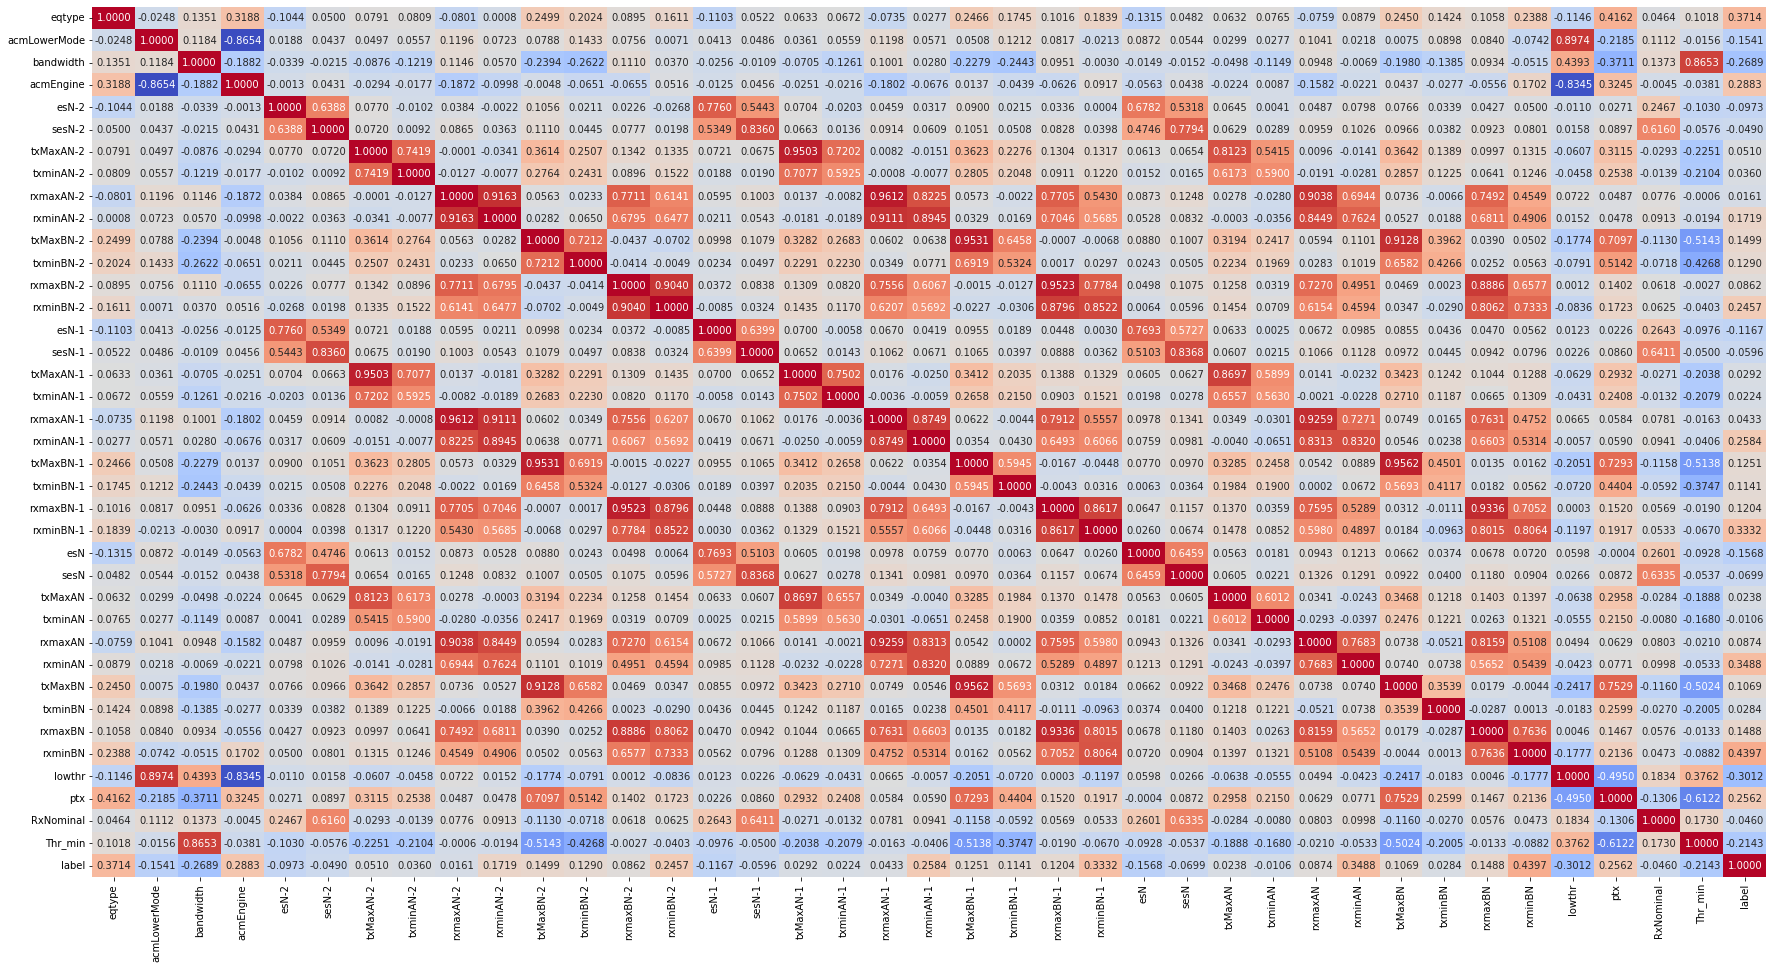

In [ ]:
corr = data.corr()

import seaborn as sns
fig, ax = plt.subplots(figsize=(30, 16))
sns.heatmap(corr, annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal')
plt.savefig("corr.png", bbox_inches='tight', pad_inches=0.0)

corr.style.background_gradient(cmap='coolwarm')

### Data Visualization

In [ ]:
# Given the dataset (data) and the name of the feature to plot (feature_name),
# it plots a stacked bar plot with a bar for each label representing the
# probability of having a particular value of the feature conditioned to the label

def plot_discrete_feature_probability(feature_name, data, filename="fig"):
  labels = range(0,6)
  feature_values = data[feature_name].unique()

  x = data[['label', feature_name]]

  percentages = []
  for i in range(len(feature_values)):
    percentages.append([])

  for l in labels:
    a = x[x['label']==l]
    for index, value in enumerate(feature_values):
      percentages[index].append(a[a[feature_name]==value].shape[0]/a.shape[0])

  fig, ax = plt.subplots(figsize=(12, 8))

  for index, value in enumerate(feature_values):
    bar_label = feature_name + '=' + str(value)
    bar_bottom = np.sum(percentages[:index], axis=0)
    ax.bar(labels, percentages[index], label=bar_label, bottom=bar_bottom)

  ax.set_ylabel('Probability')
  ax.set_xlabel('Failure Type')
  ax.set_title(feature_name + ' probability conditioned to the Failure Type')
  ax.set_yticks(ticks=np.linspace(0, 1, 11))
  ax.set_ylim(top=1.05)
  ax.legend()
  ax.grid()

  plt.savefig(str(filename)+".png", bbox_inches='tight', pad_inches=0.0)

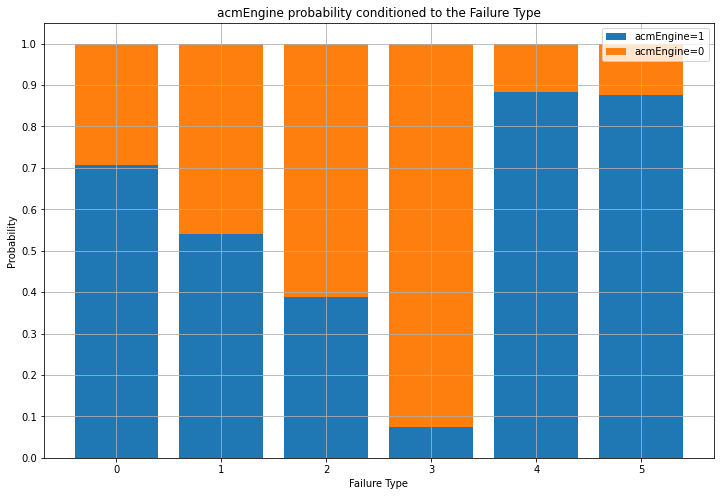

In [ ]:
plot_discrete_feature_probability('acmEngine', data, "acmEngine_FailureType")

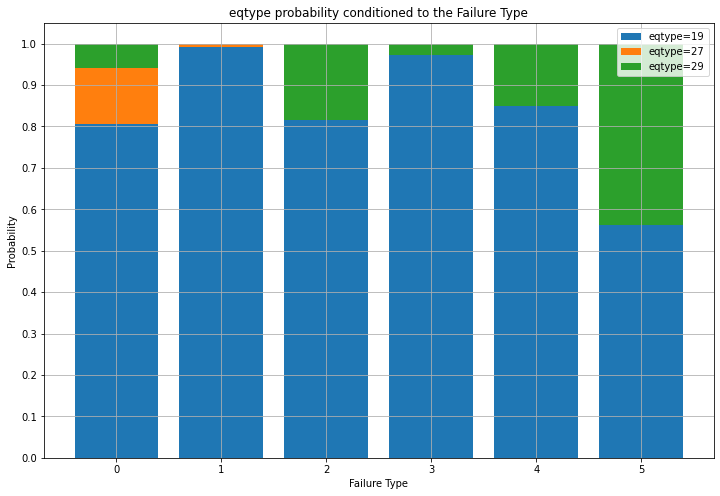

In [ ]:
plot_discrete_feature_probability('eqtype', data, "eqType_FailureType")

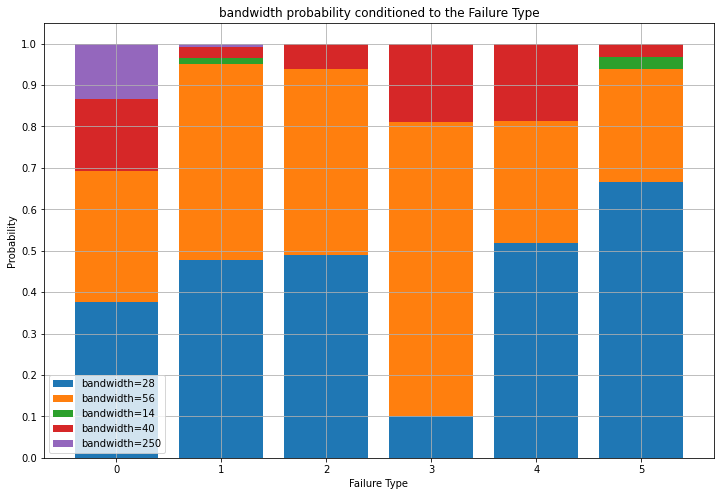

In [ ]:
plot_discrete_feature_probability('bandwidth', data)

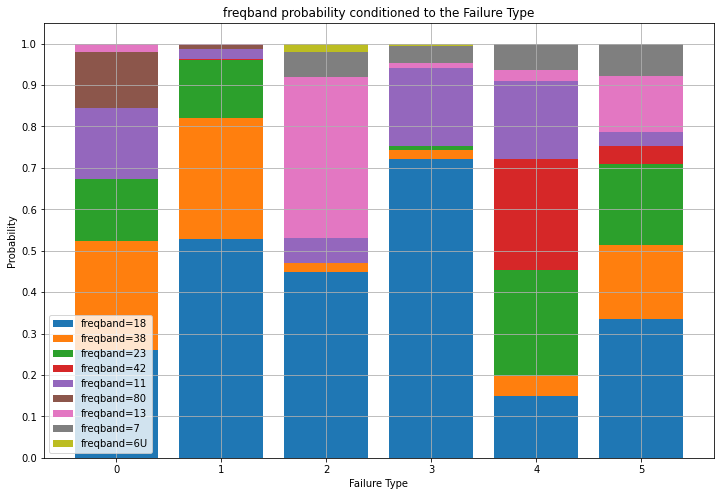

In [ ]:
plot_discrete_feature_probability('freqband', data, "freqband_FailureType")

In [ ]:
# Given the dataset (data) and the name of the feature to plot (feature_name),
# it plots the distribution conditioned to each label

def plot_feature_probability(feature_name, data, filename="fig"):
  fig, ax = plt.subplots(figsize=(12, 8))

  x = data[feature_name]
  y = data['label']
  ax.plot(x, y, 'o', alpha=0.1)

  ax.set_ylabel('Failure Type')
  ax.set_xlabel(feature_name)
  ax.set_title(feature_name + ' distribution conditioned to the Failure Type')

  ax.grid()

  plt.savefig(str(filename)+".png", bbox_inches='tight', pad_inches=0.0)

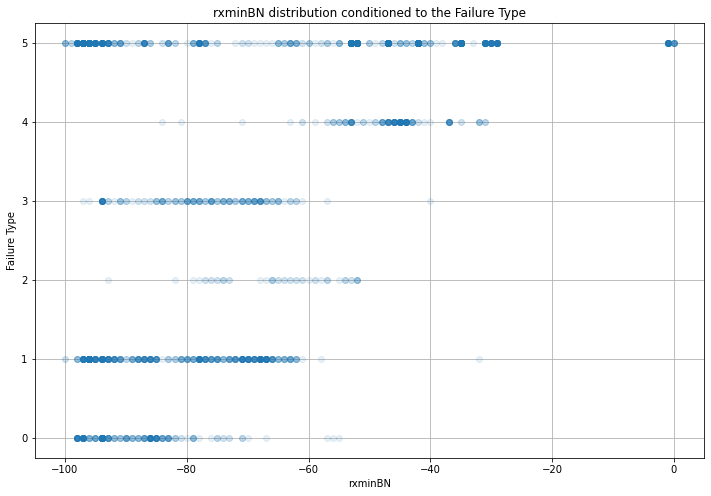

In [ ]:
plot_feature_probability('rxminBN', data, "rxminBN_FailureType")

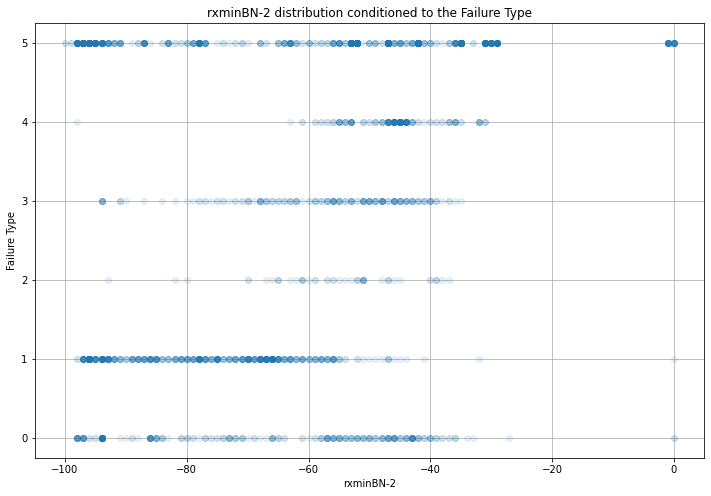

In [ ]:
plot_feature_probability('rxminBN-2', data, "rxminBN-2_FailureType")

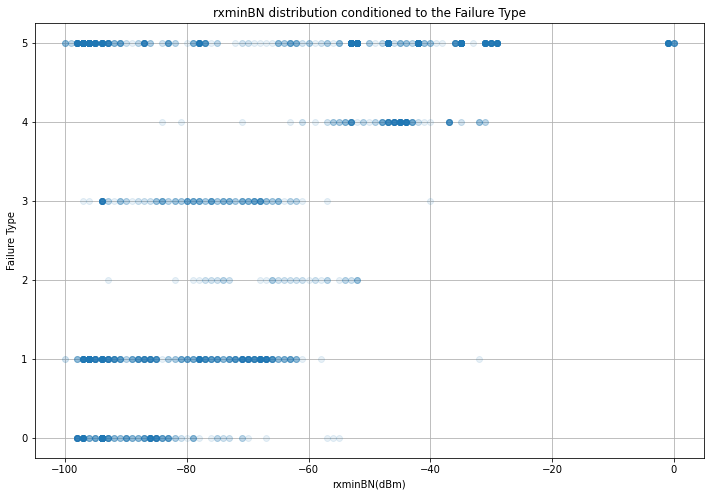

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

x = data['rxminBN']
y = data['label']
ax.plot(x, y, 'o', alpha=0.1)

ax.set_ylabel('Failure Type')
ax.set_xlabel('rxminBN(dBm)')
ax.set_title('rxminBN distribution conditioned to the Failure Type')

ax.grid()

### NaN values

In [ ]:
print("The number of NaN values in the dataframe is",data[data.isnull().any(axis=1)].shape[0])

The number of NaN values in the dataframe is 363


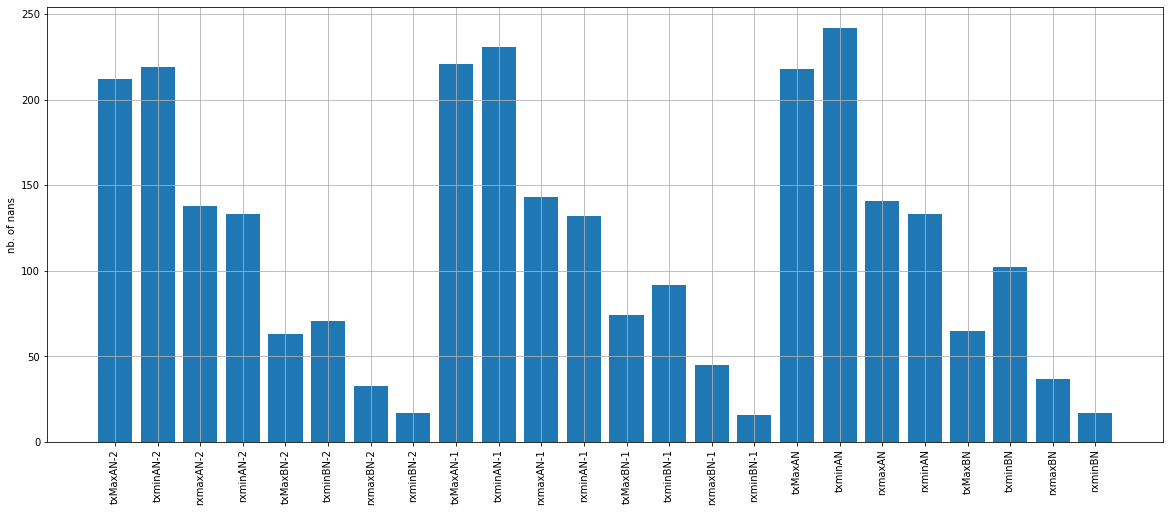

In [ ]:
nb_nan = []
feature_names = []

for col in data.columns:
  if data[col].isna().sum() > 0:
    nb_nan.append(data[col].isna().sum())
    feature_names.append(col)

fig, ax = plt.subplots(figsize=(20, 8))

ax.bar(feature_names, nb_nan)
ax.set_ylabel('nb. of nans')
_ = plt.xticks(rotation='vertical')
plt.grid()

plt.savefig("Nb_NaNs.png", bbox_inches='tight', pad_inches=0.0)

Let's check whether there is any relation between rows with NaN values and the failure type. This will be useful later in the data preprocessing to choose how to replace them.

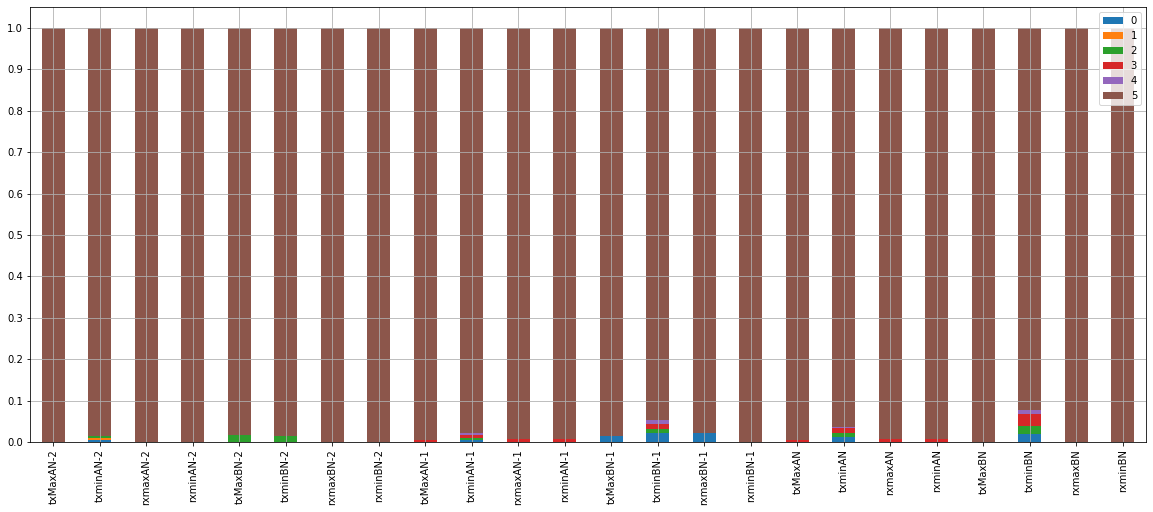

In [ ]:
# Plot a bar plot on a figure where each bar represents the distribution of 
# labels conditioned to the specific feature
fig, ax = plt.subplots(figsize=(20,8))

labels = range(6)


# Create the occurences list of lists [feature][label occurences]
occurences = [[] for x in range(len(feature_names))]

for index,col in enumerate(feature_names):
  x = data[[col, 'label']]
  
  for label in labels:
    label_specific_data = x[x['label'] == label]
    occurences[index].append(label_specific_data[label_specific_data.isnull().any(axis=1)].shape[0])

occurences_df = pd.DataFrame(data=occurences, columns=labels, index=feature_names)
occurences_df = occurences_df.div(occurences_df.sum(axis=1), axis=0) 
_ = occurences_df.plot.bar(stacked=True, ax=ax, rot=90, legend=True, grid=True, yticks=np.linspace(0, 1, 11))
plt.savefig("NaNs_FailureType_Correlation.png", bbox_inches='tight', pad_inches=0.0)

NaN values are mainly due to hardware failure, in the first part we will with the median value (already done in class and could lead to data leakages). <br>
The use of datawig can then be evaluated.We can try datawig https://github.com/awslabs/datawig 
(For now let us use the media value in order to to plot the outliers).

### Outliers

In [ ]:
def plot_outliers(data,featurenumber=0):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (20,8))

  fig.suptitle(data.columns.values[featurenumber])

  _ = axs[0].boxplot([data.iloc[:,featurenumber]],
              labels=[data.columns.values[featurenumber]])
  _ = axs[0].grid(visible=True)

  feature = data.iloc[:,featurenumber].to_numpy()
  minvalue = feature.min()
  maxvalue = feature.max()

  y, x, _ = axs[1].hist(feature, bins = min(100, 1 + int(maxvalue-minvalue)))
  _ = axs[1].set_ylim(top= y.max() * 1.05)
  _ = axs[1].set_xlabel(data.columns.values[featurenumber])
  _ = axs[1].set_ylabel('No. of occurrences')
  _ = axs[1].grid(visible=True)

  plt.show()


['eqtype' 'acmLowerMode' 'freqband' 'bandwidth' 'acmEngine' 'esN-2'
 'sesN-2' 'txMaxAN-2' 'txminAN-2' 'rxmaxAN-2' 'rxminAN-2' 'txMaxBN-2'
 'txminBN-2' 'rxmaxBN-2' 'rxminBN-2' 'esN-1' 'sesN-1' 'txMaxAN-1'
 'txminAN-1' 'rxmaxAN-1' 'rxminAN-1' 'txMaxBN-1' 'txminBN-1' 'rxmaxBN-1'
 'rxminBN-1' 'esN' 'sesN' 'txMaxAN' 'txminAN' 'rxmaxAN' 'rxminAN'
 'txMaxBN' 'txminBN' 'rxmaxBN' 'rxminBN' 'lowthr' 'ptx' 'RxNominal'
 'Thr_min' 'label']


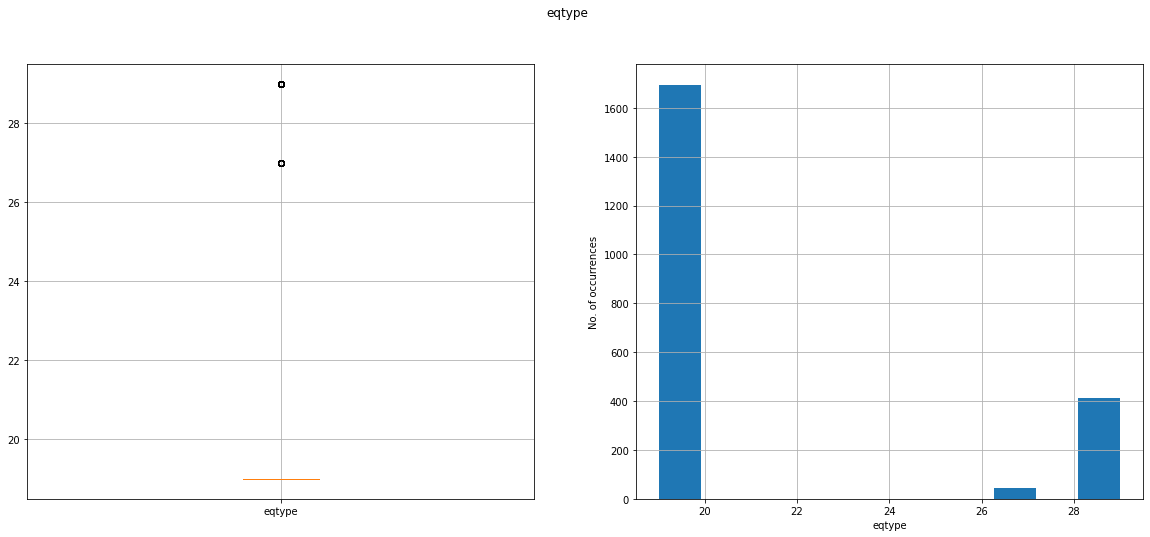

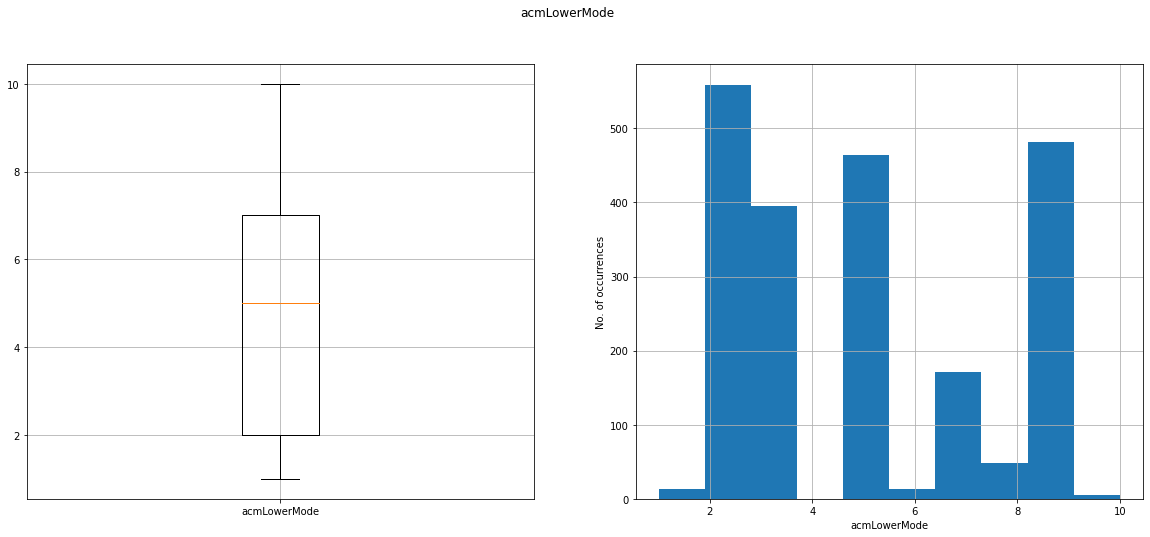

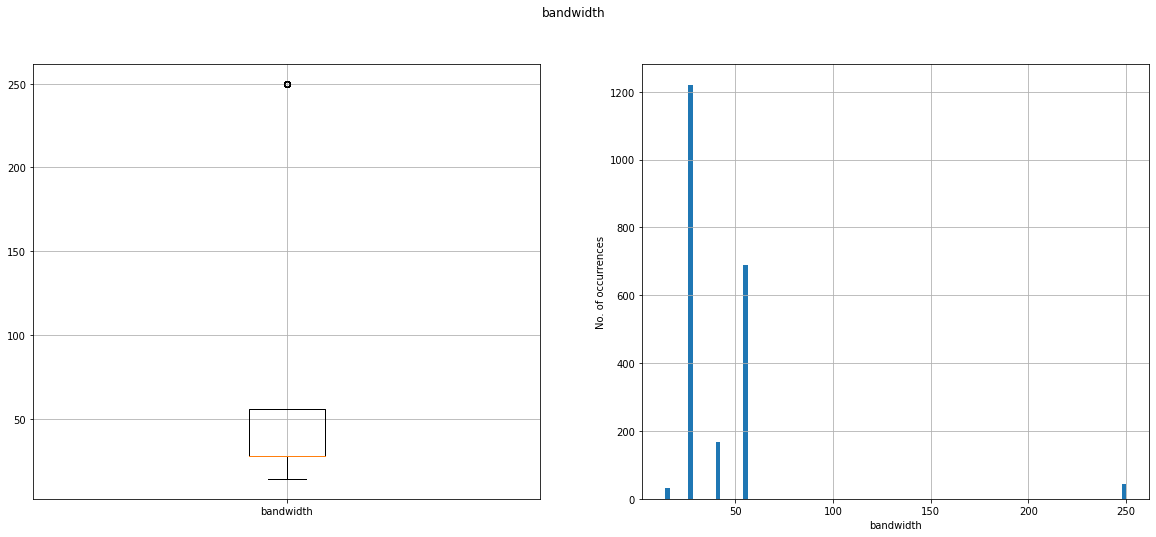

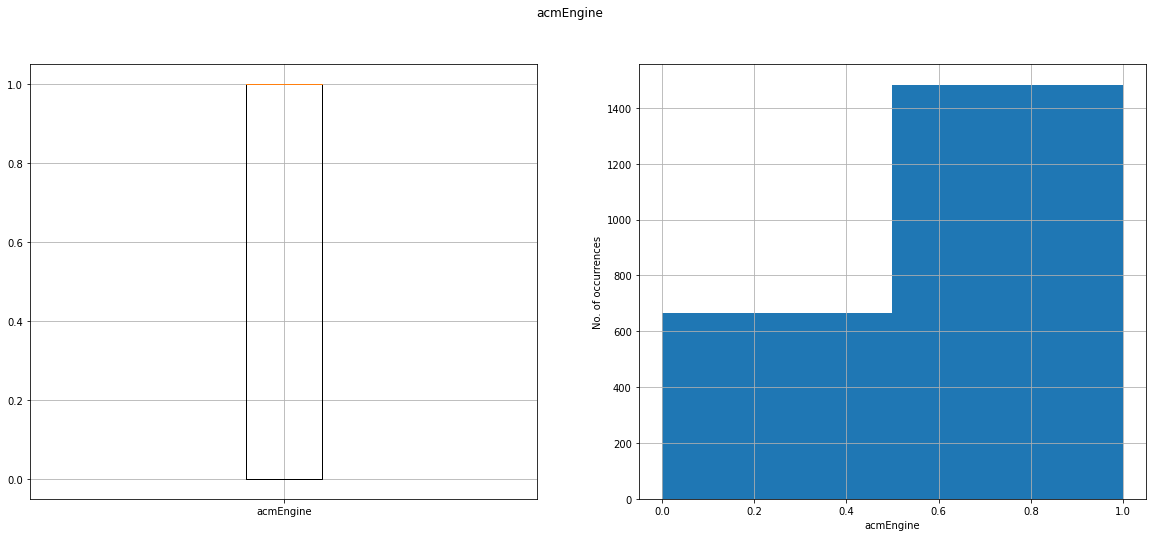

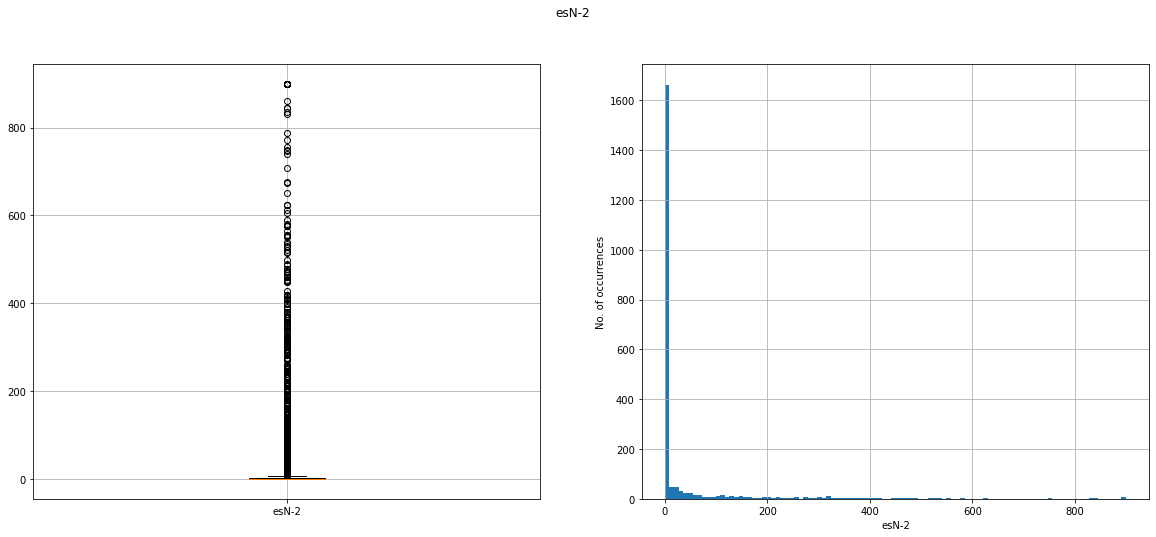

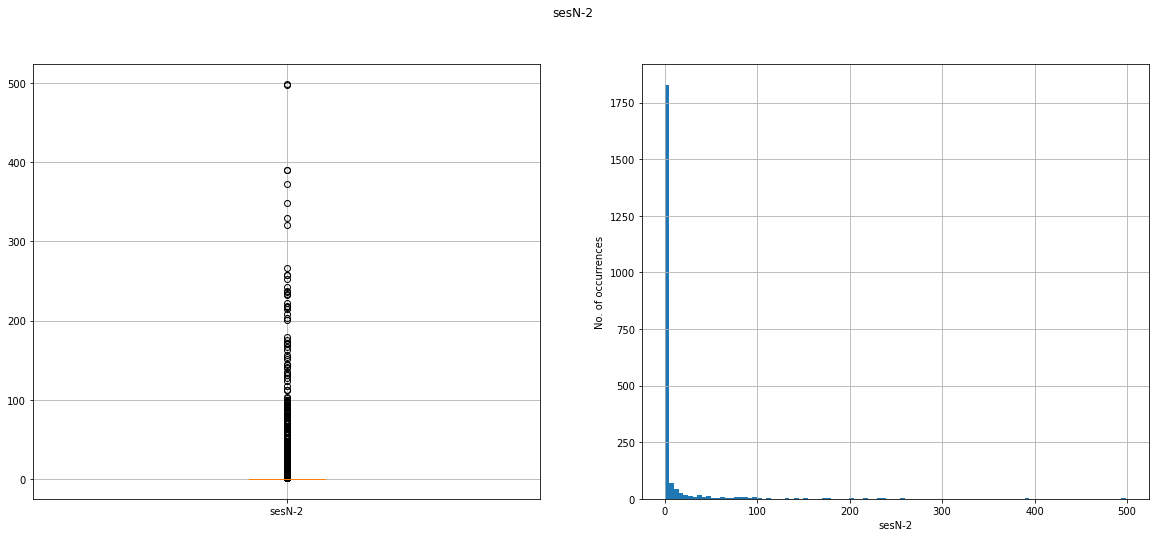

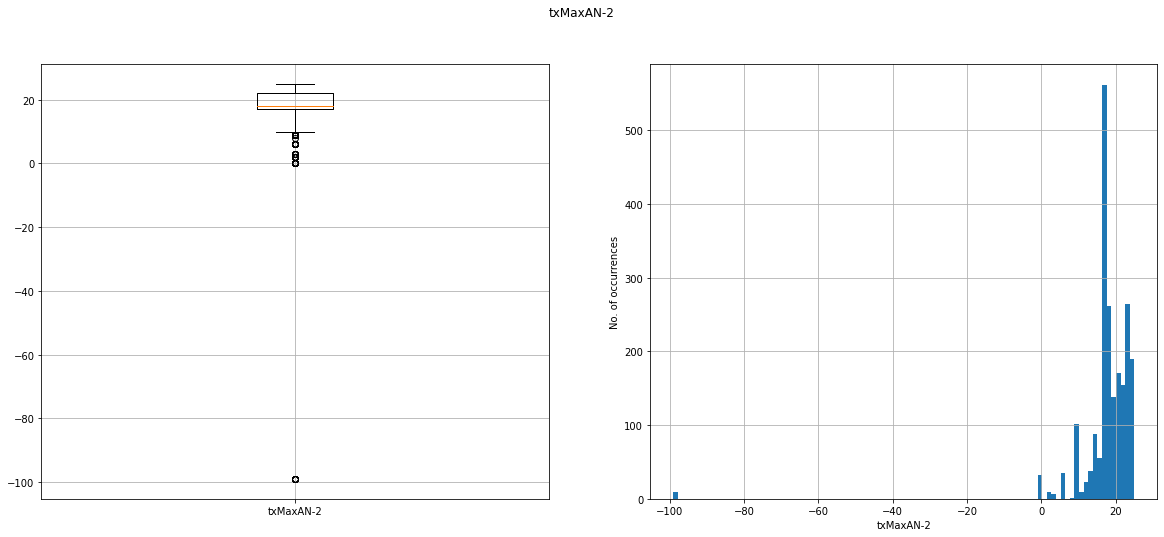

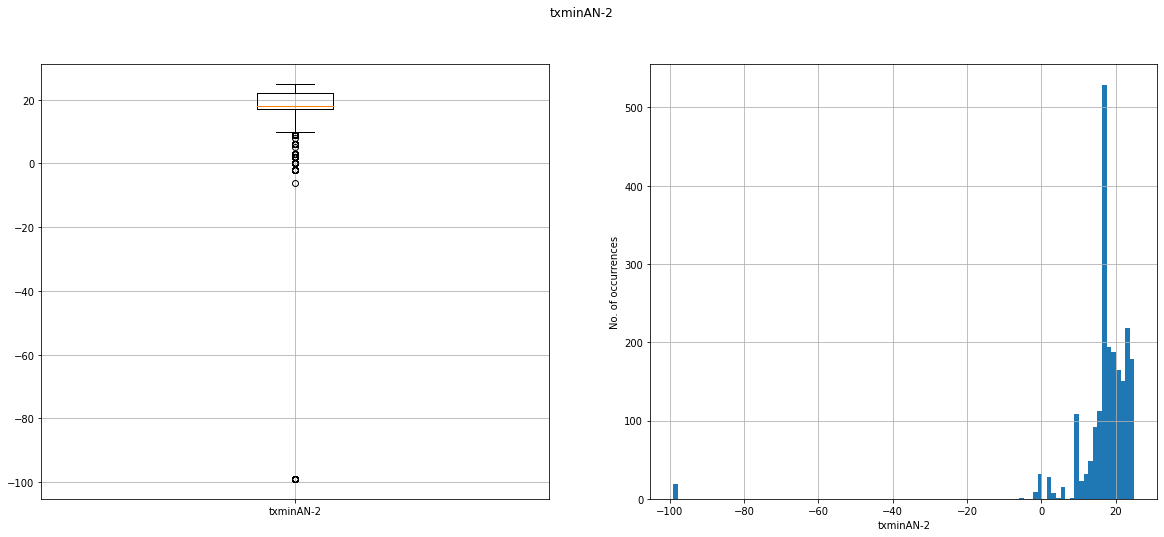

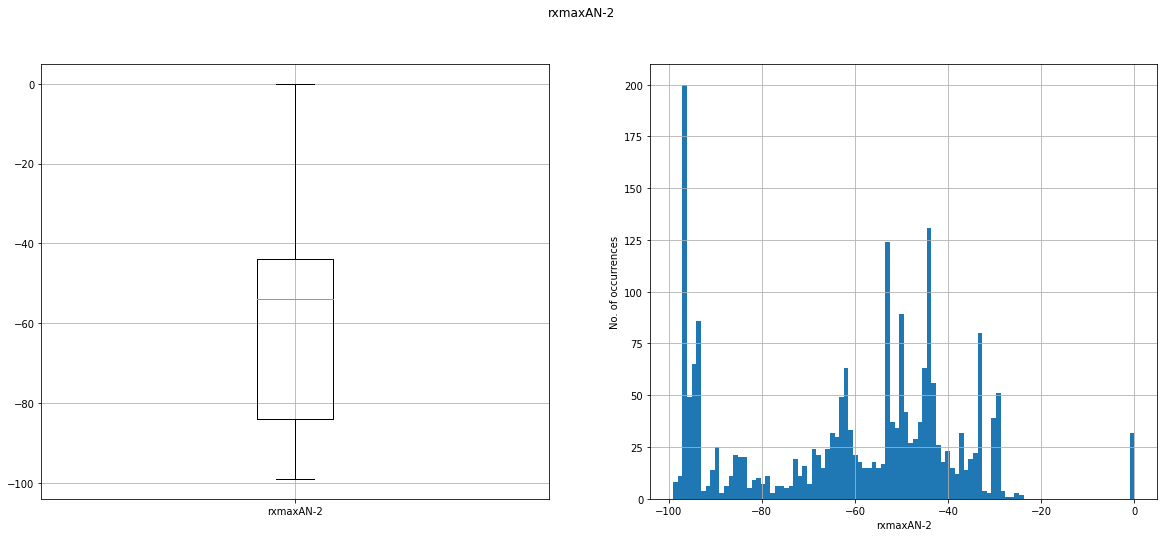

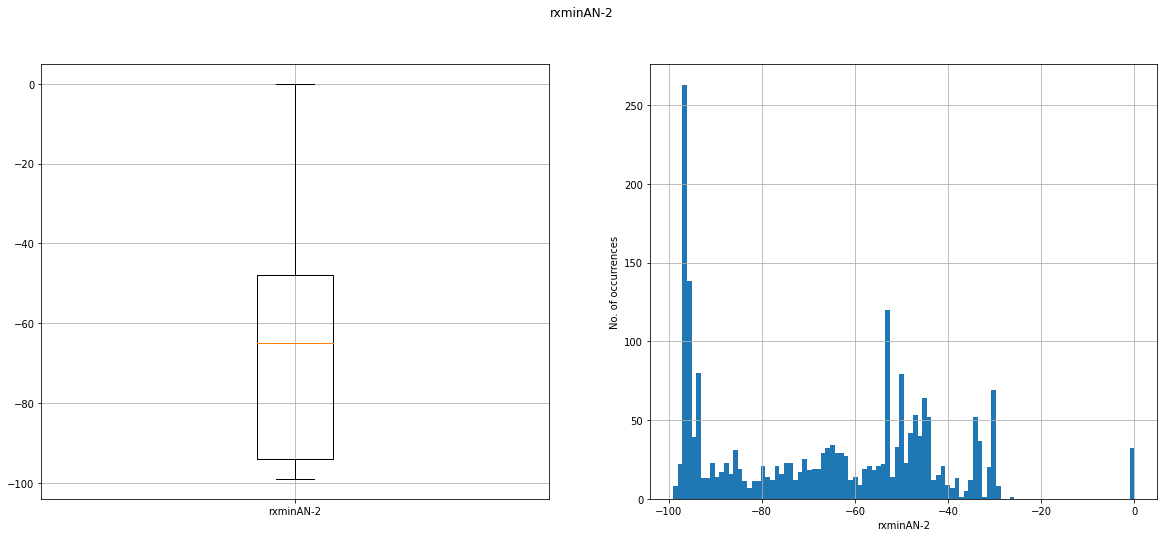

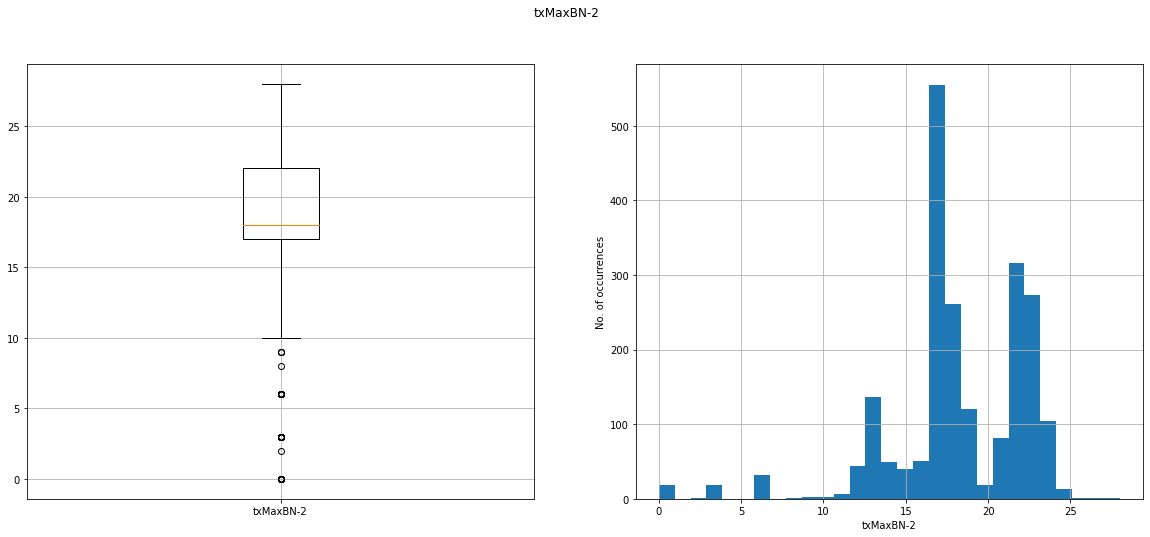

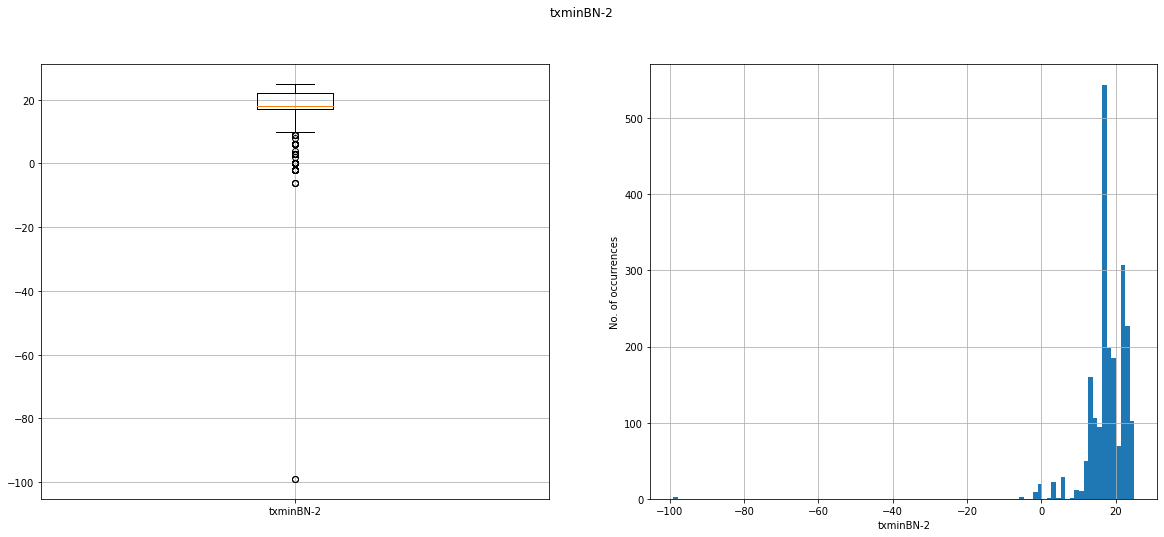

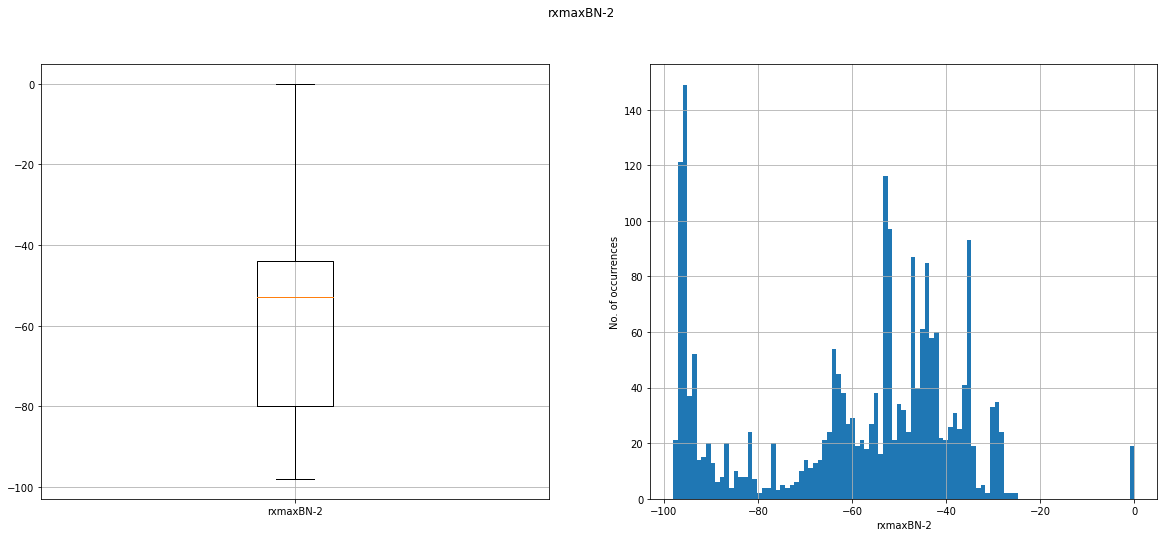

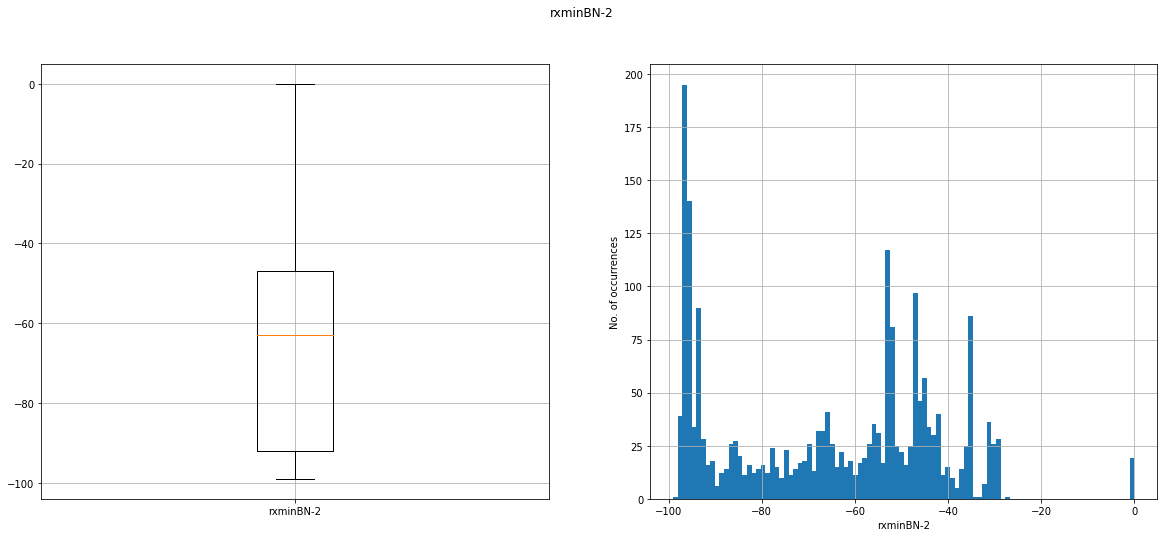

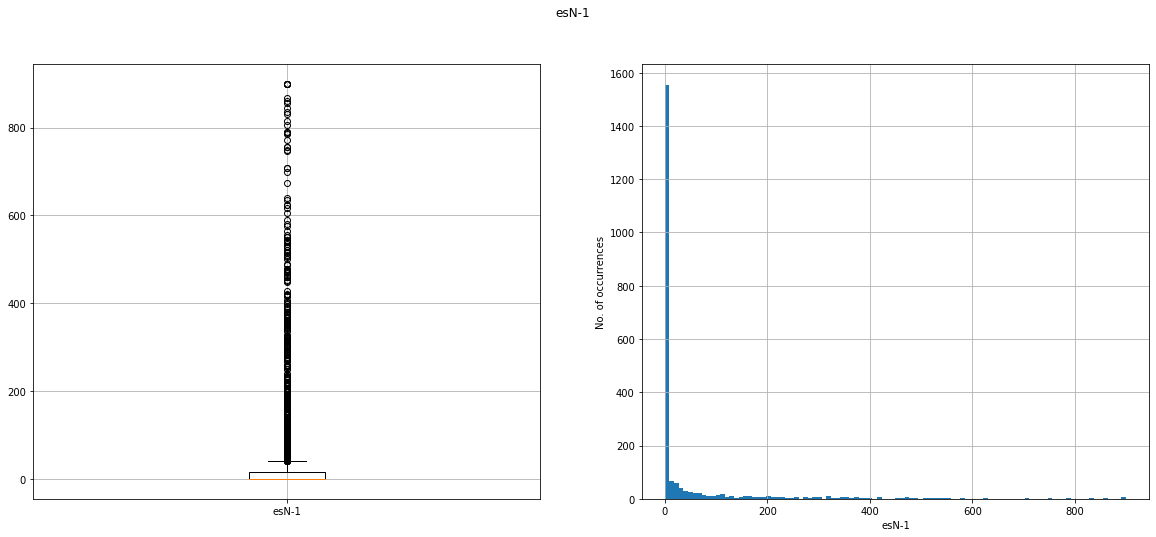

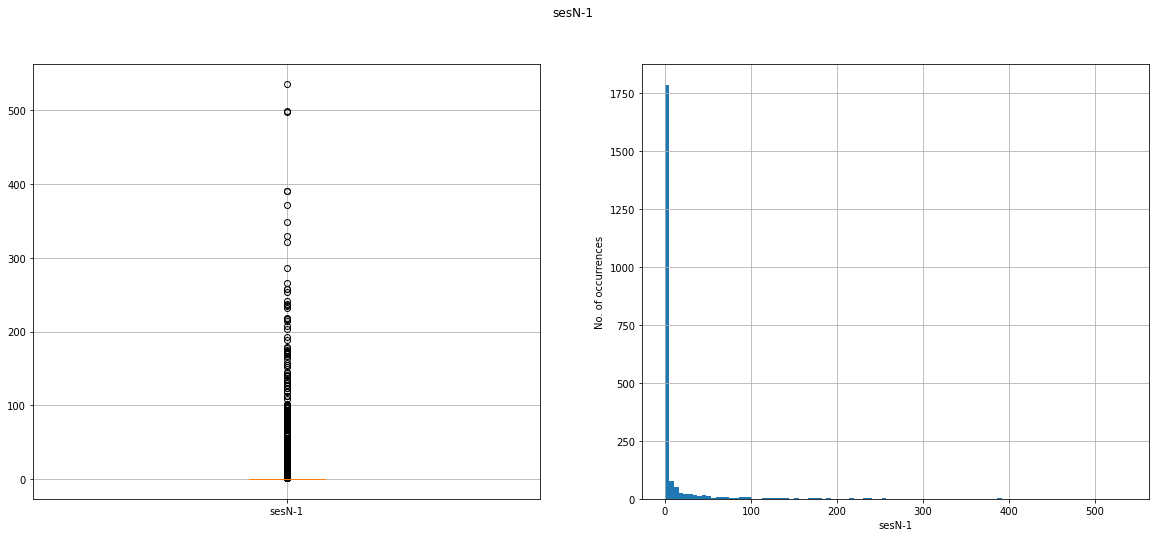

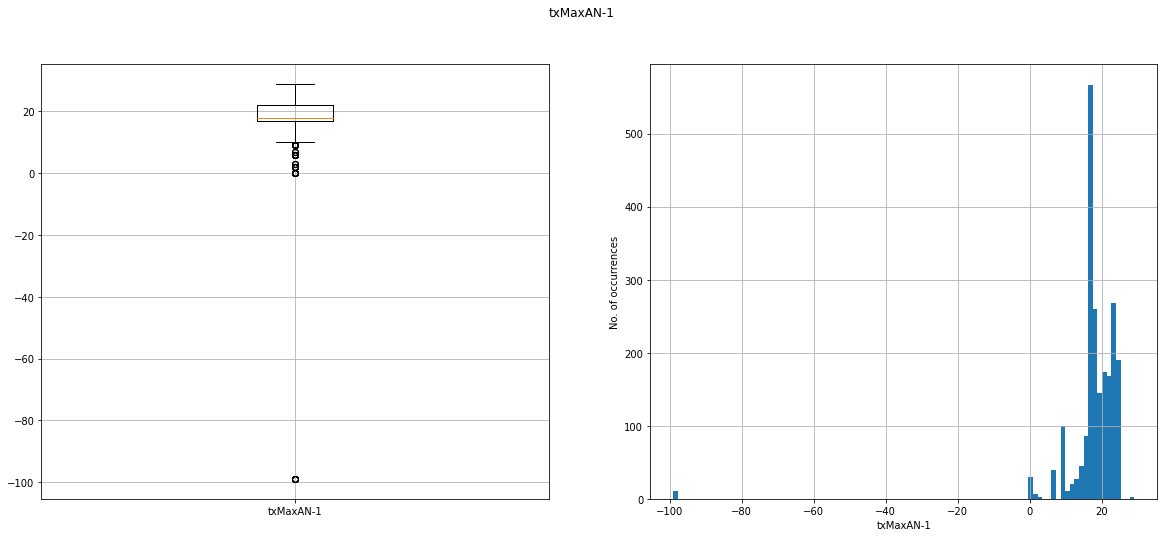

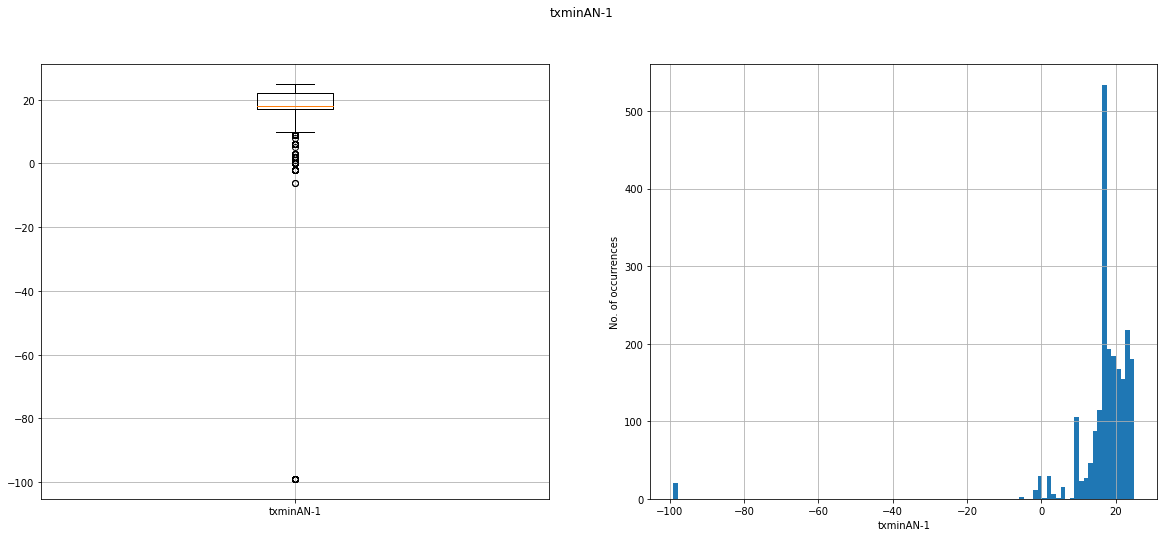

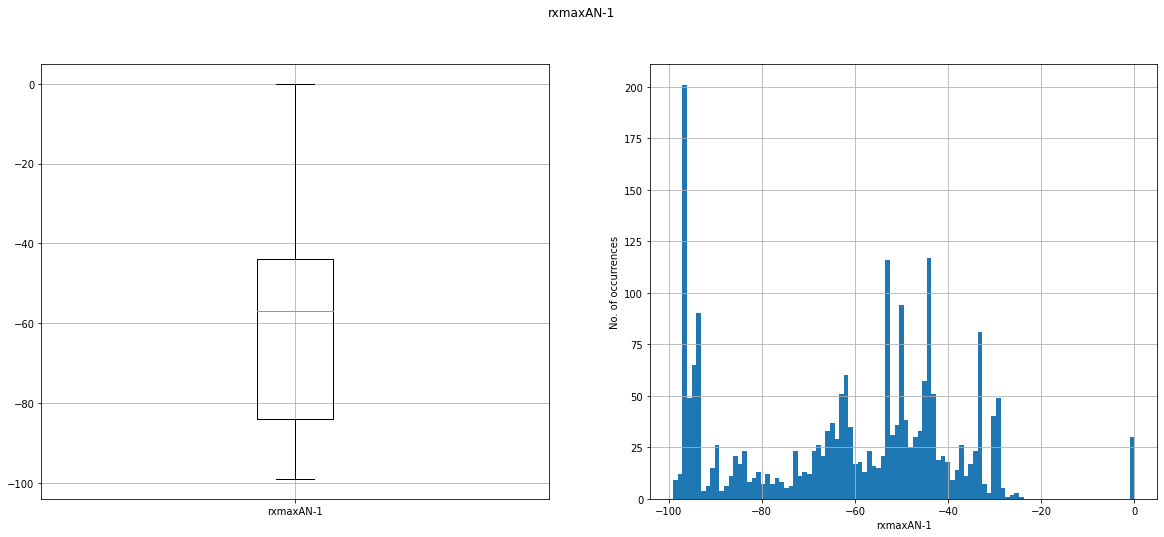

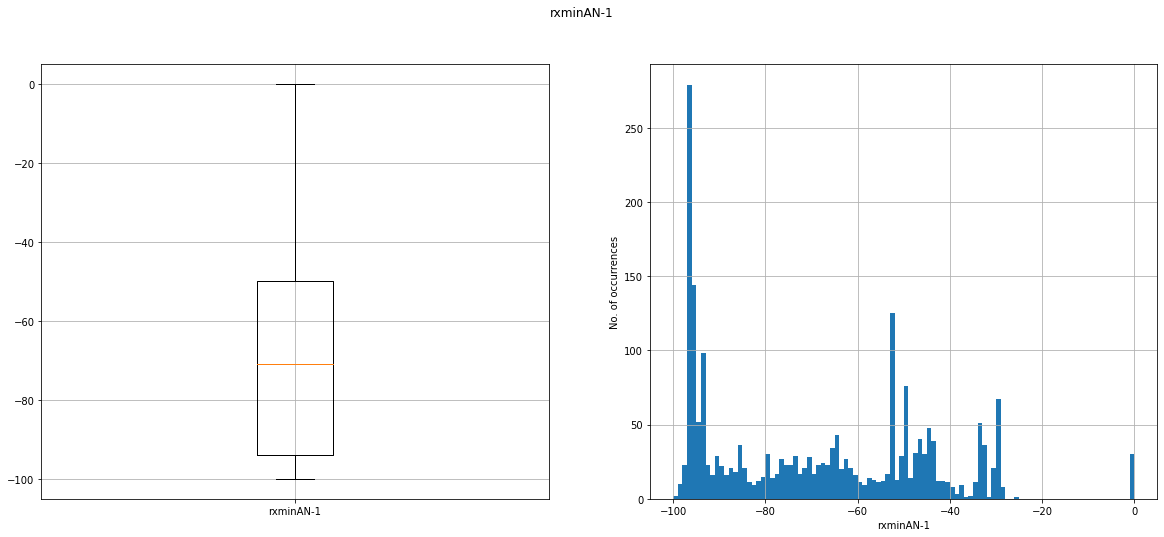

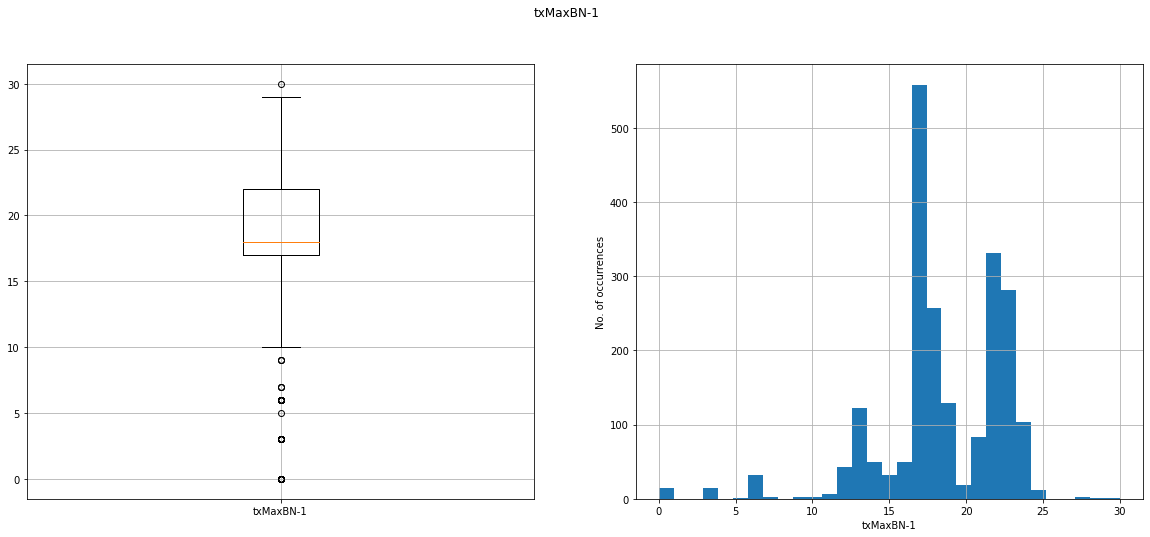

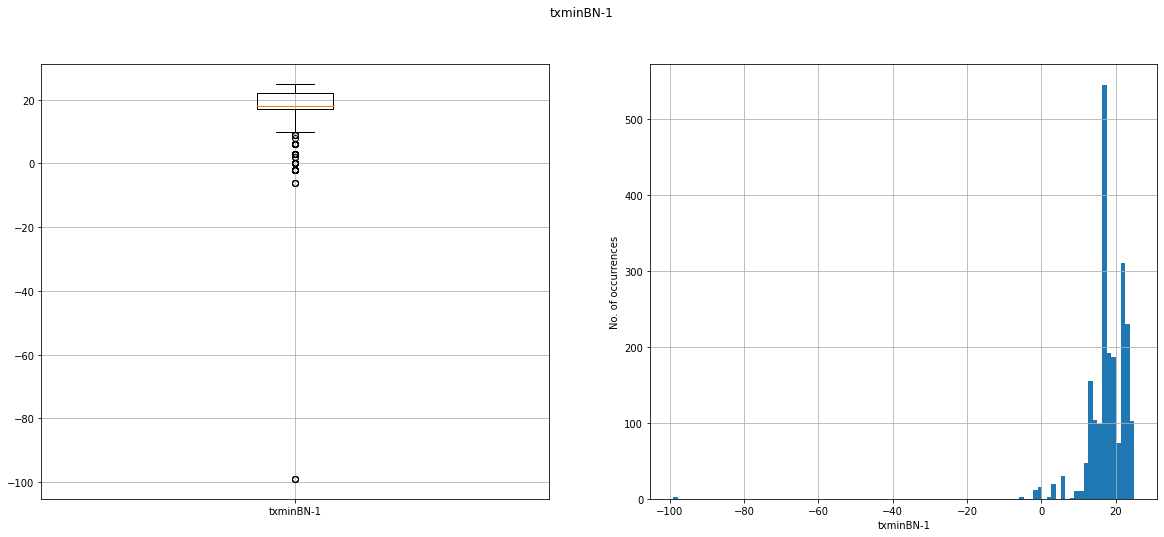

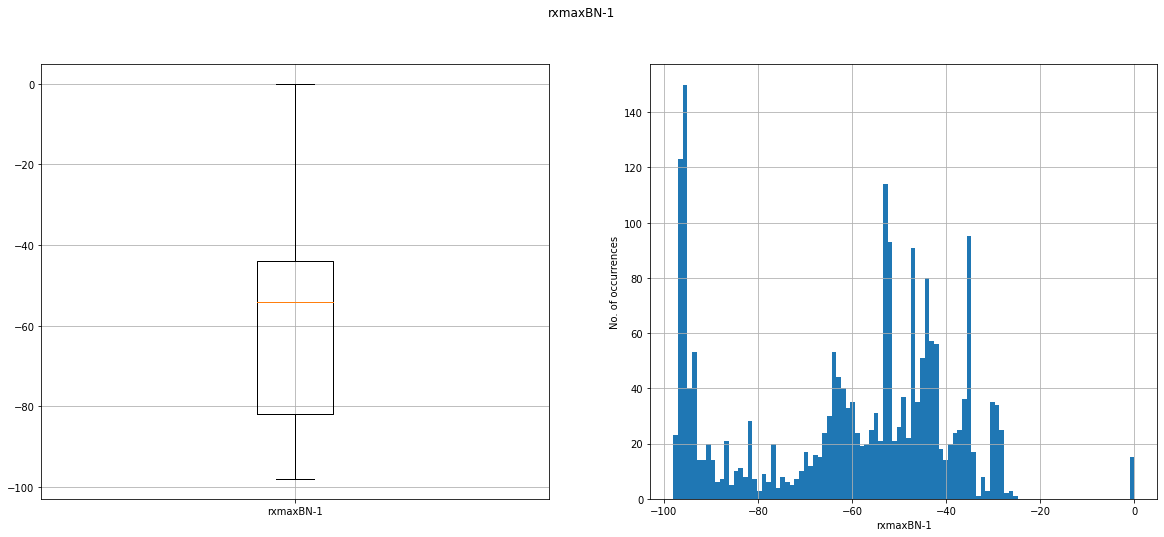

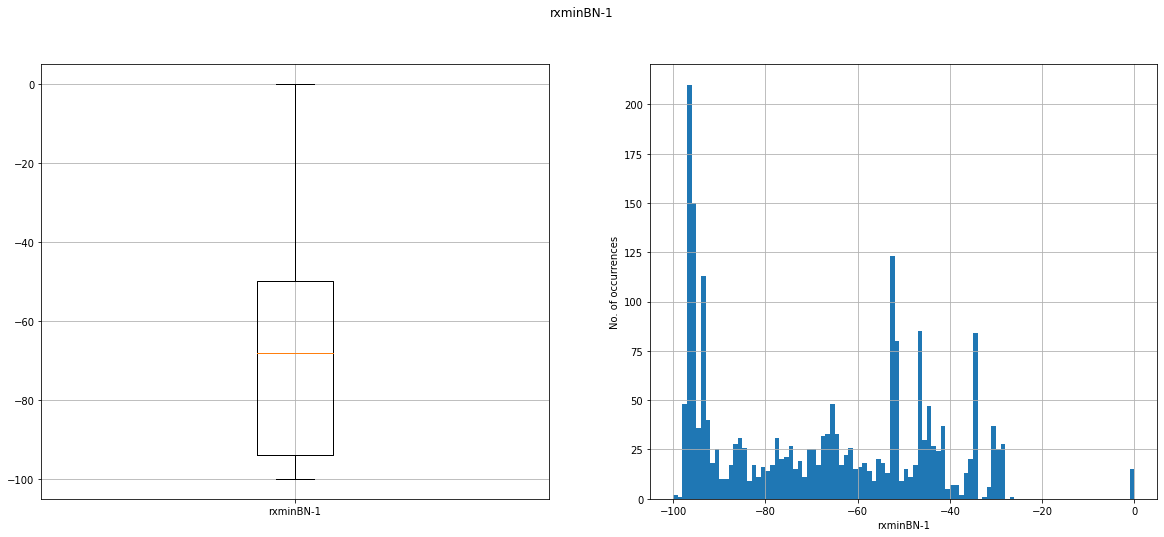

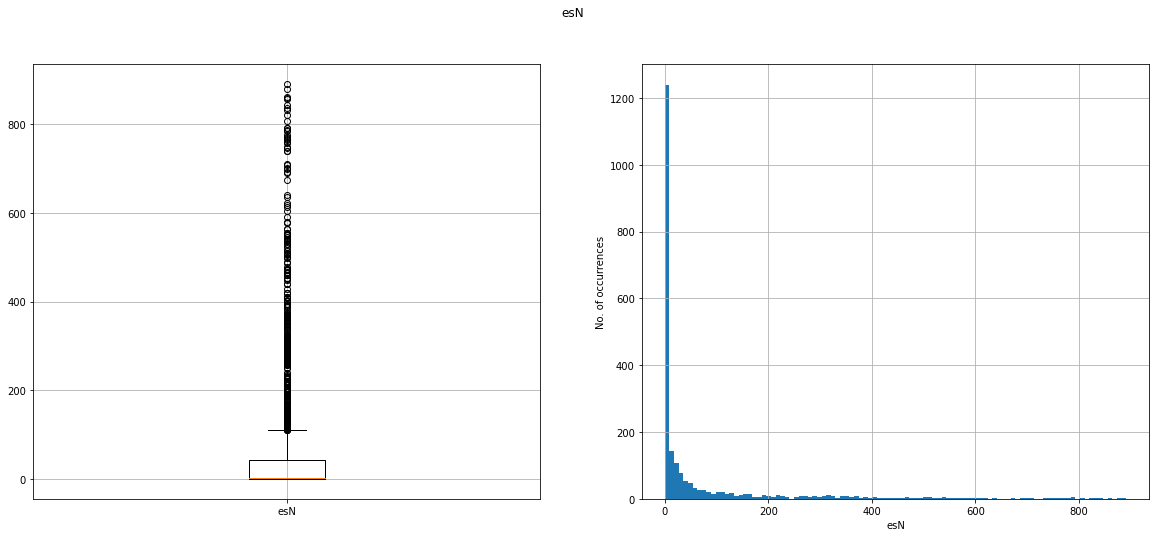

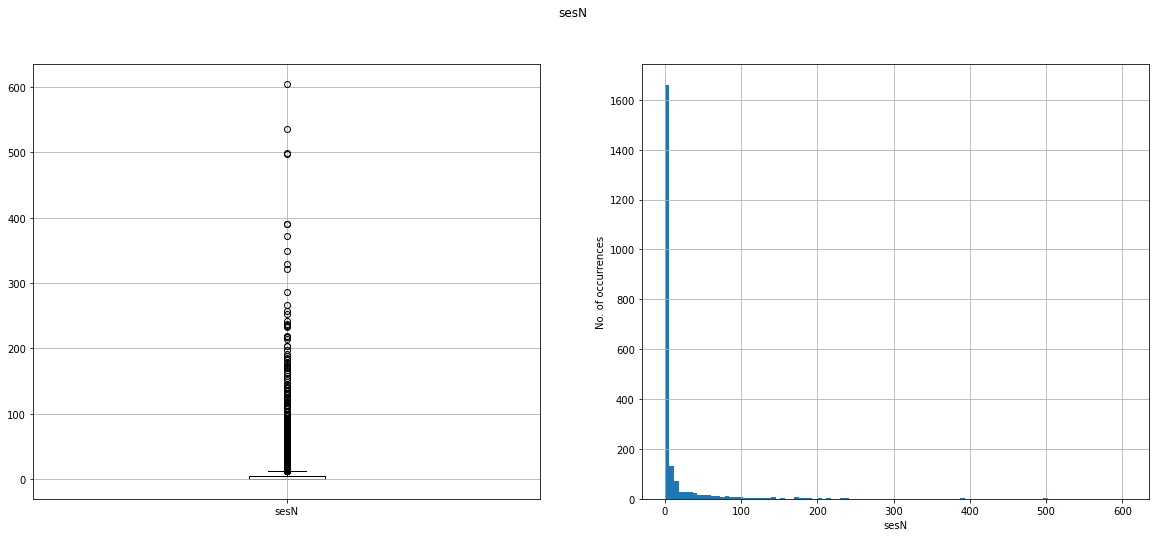

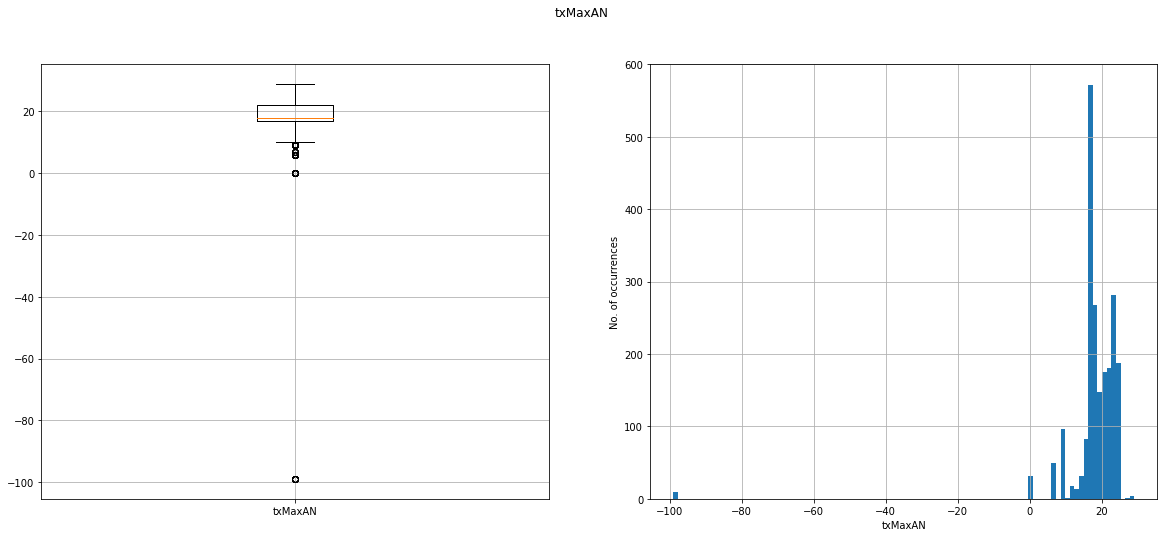

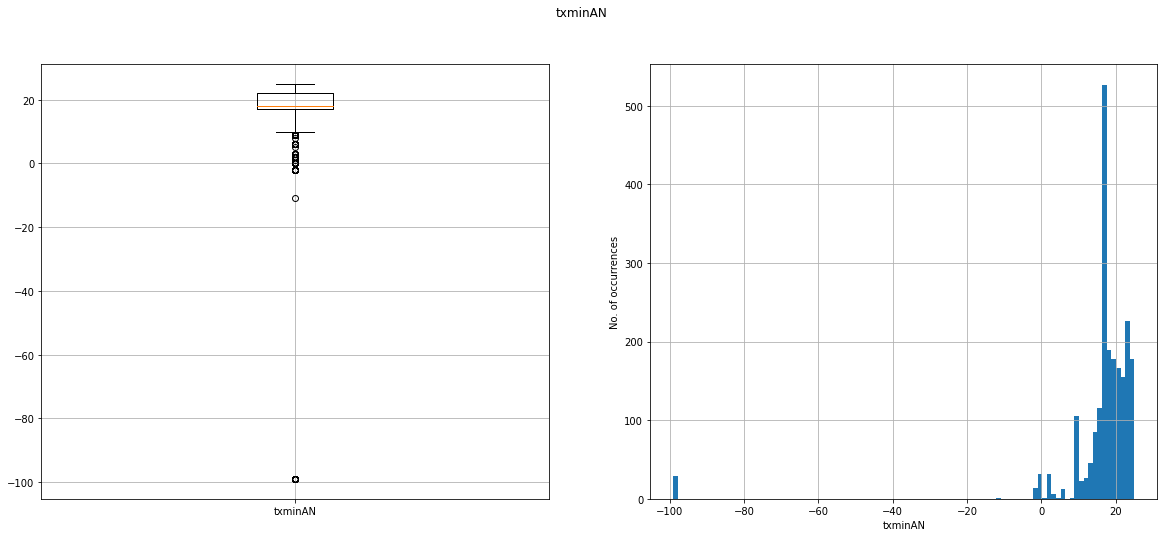

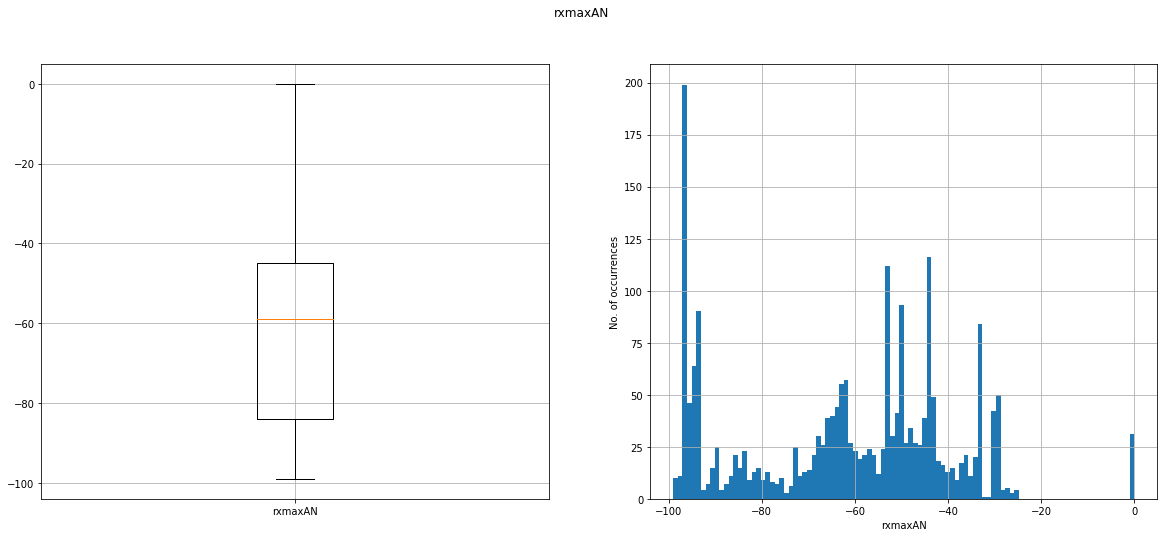

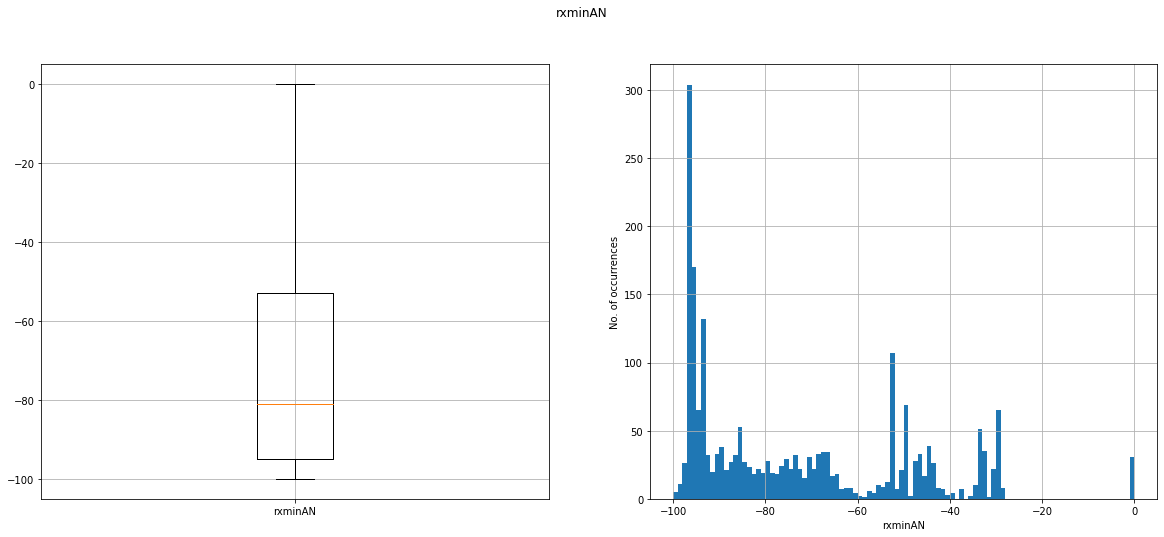

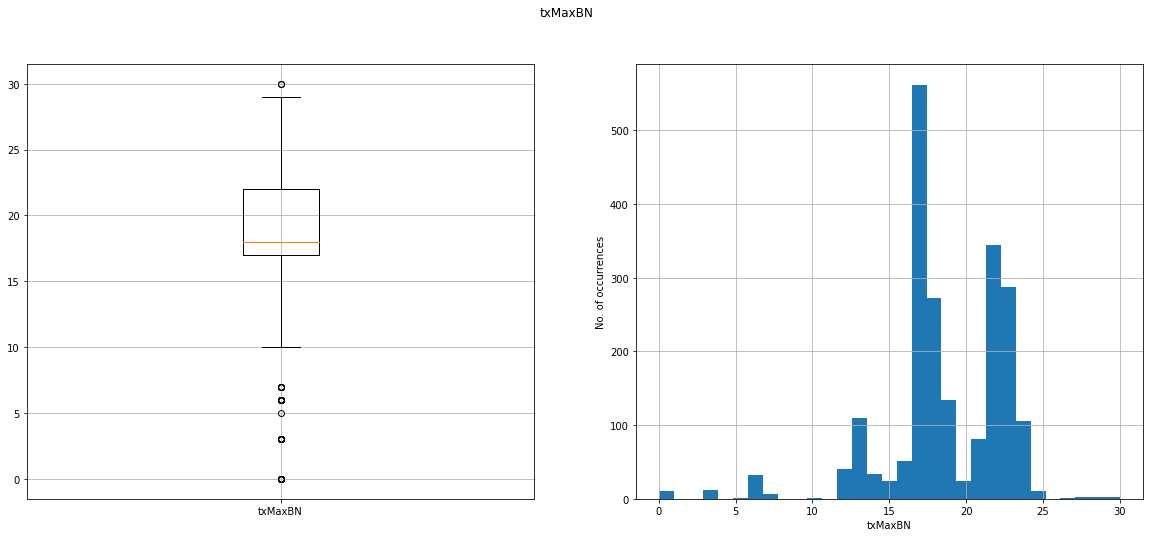

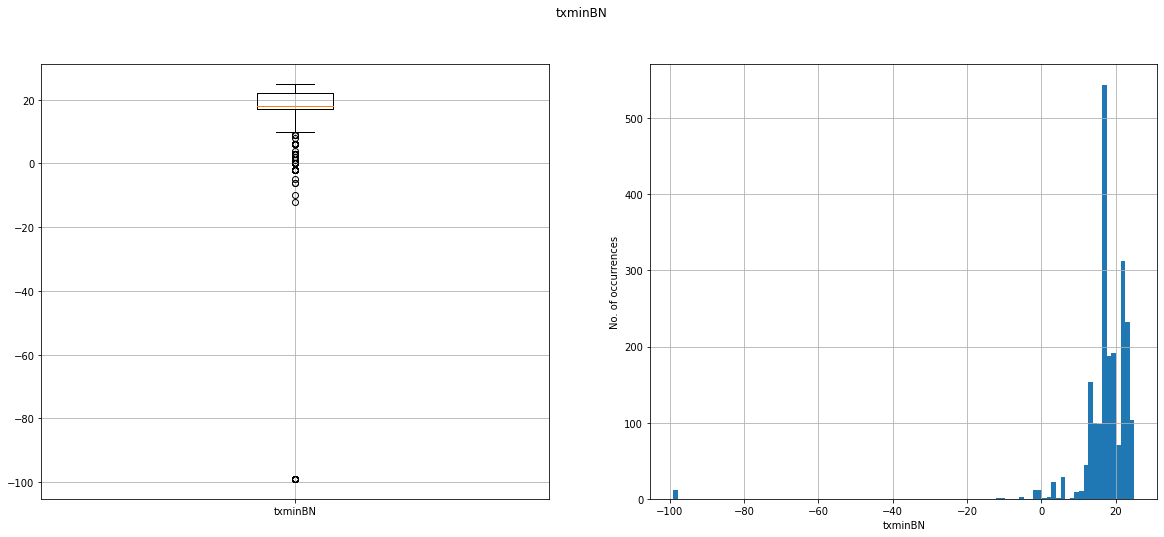

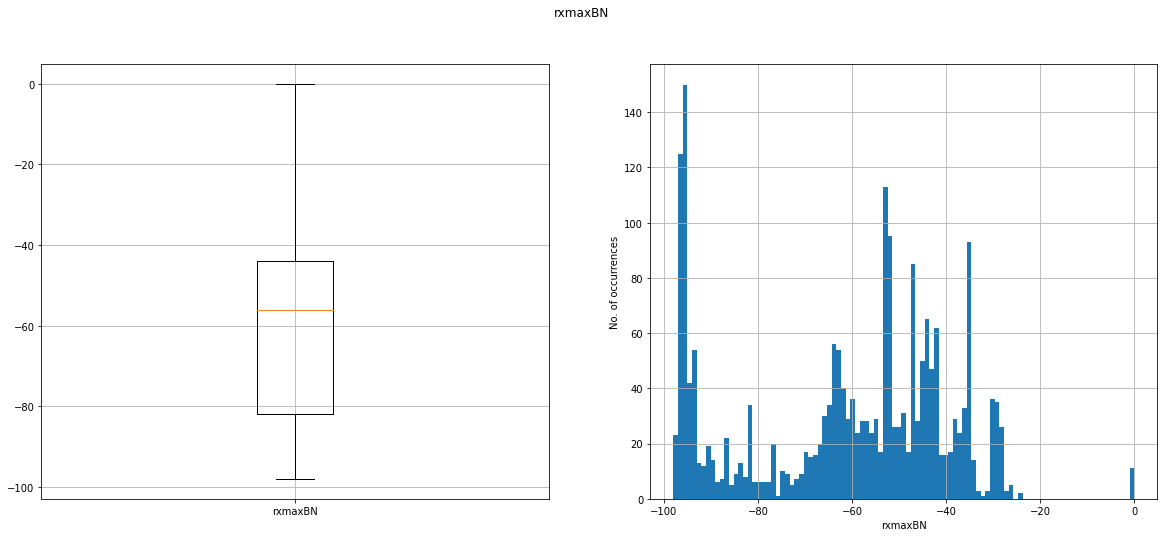

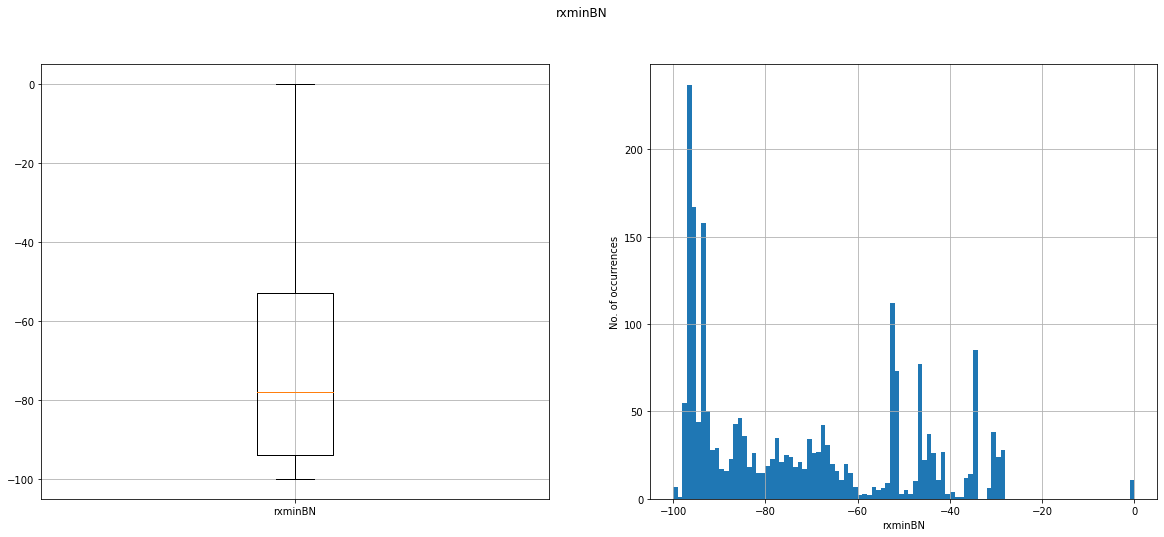

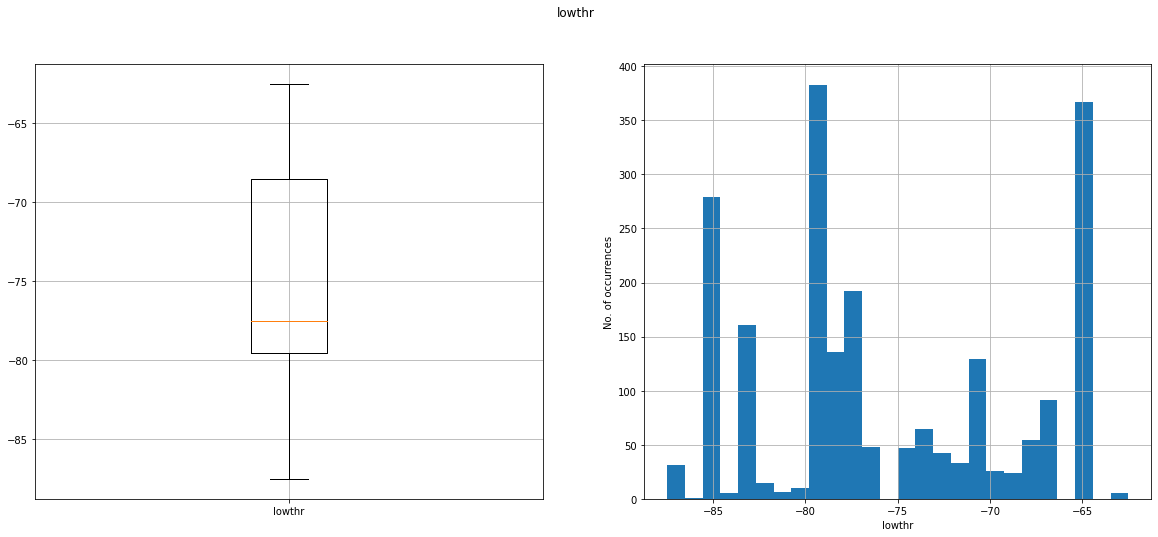

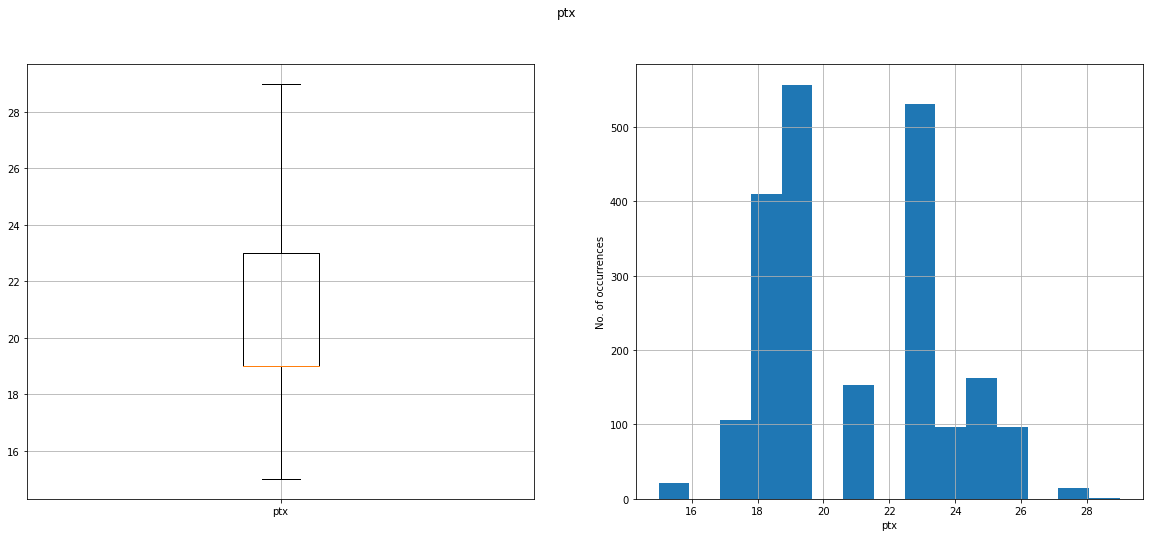

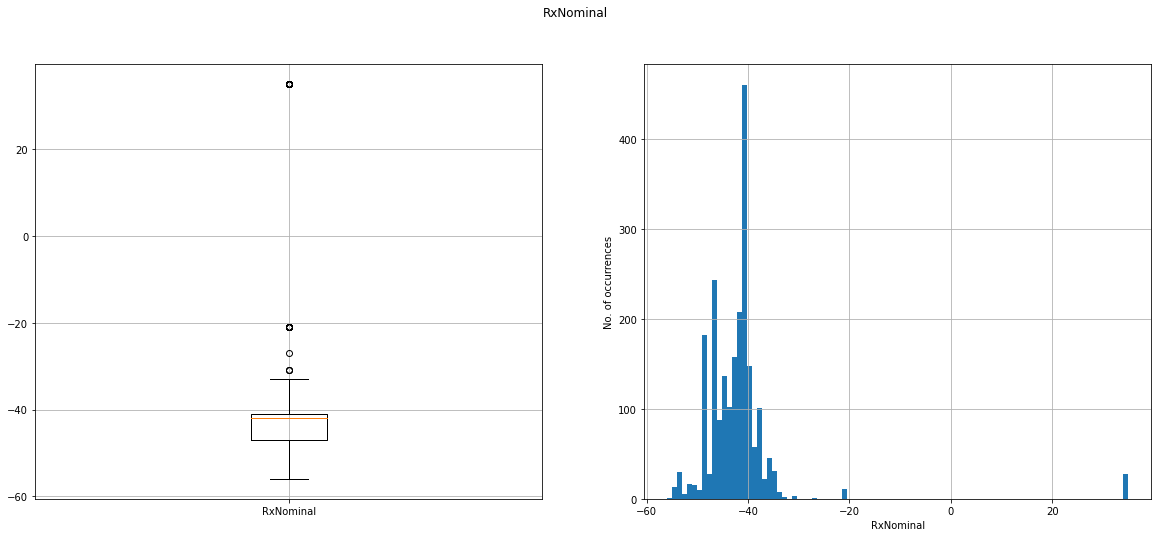

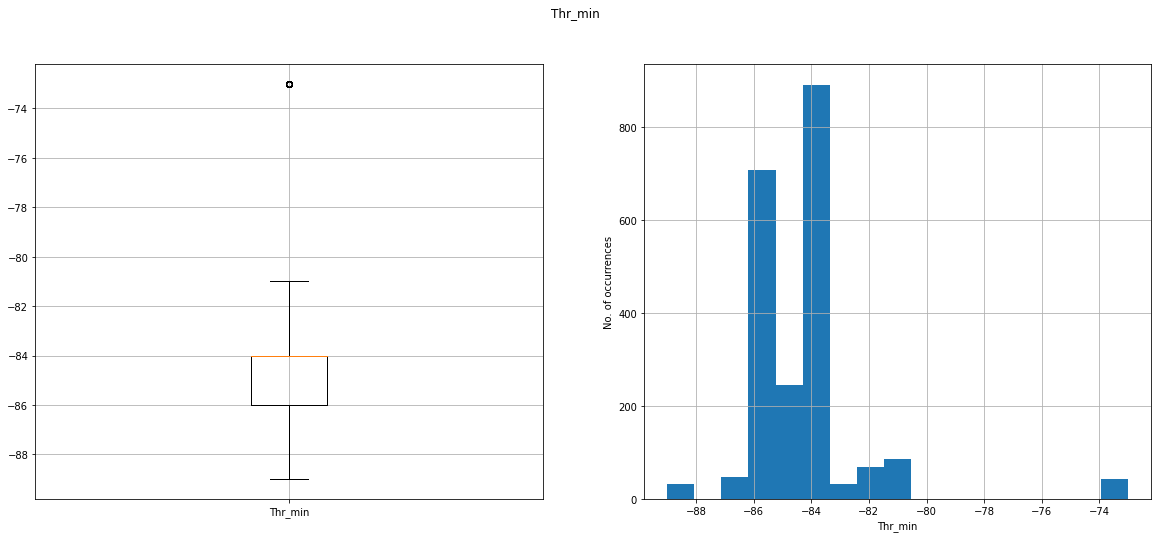

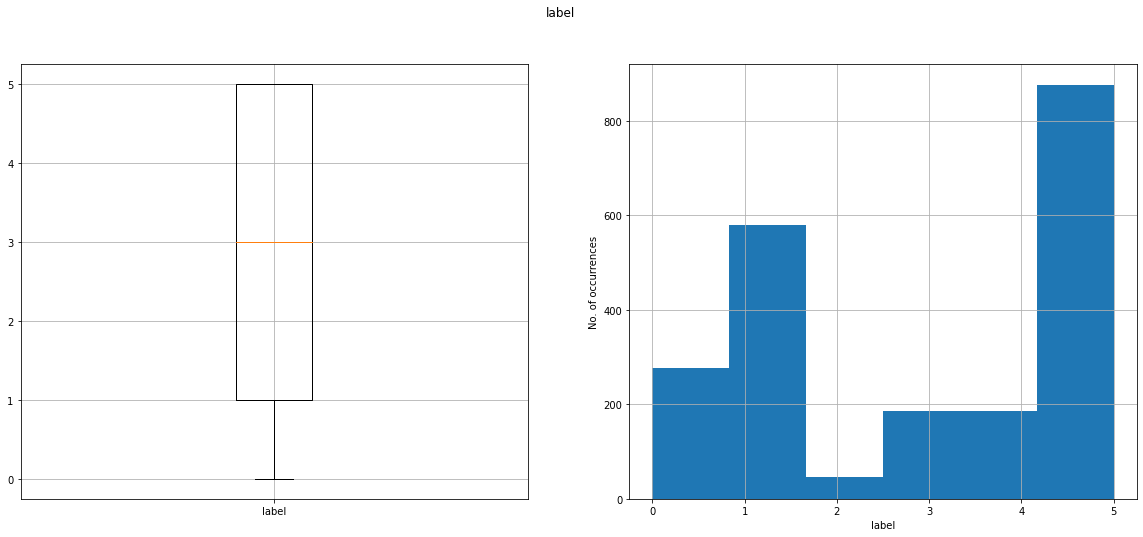

In [ ]:
print(data.columns.values)
for i in enumerate(data.columns.values):
  if(i[0]!=2):
    plot_outliers(data.dropna(),i[0])

Outliers: visualisation with probability distribution and boxplot. In this specific case, a value(s) out of the boxplot could be an indicator of failure. ex: the bandwidth's boxplot has only one outlier. For this reason, outliers are maintained as they are.

## Data Preprocessing

### Feature Removal

As done in class, initially do not consider the following features:
- eqtype
- acmLowerMode
- bandwidth
- acmEngine
- freqband

They will be eventually considered successively

In [ ]:
data.drop(columns=['eqtype', 'acmLowerMode', 'bandwidth', 'acmEngine', 'freqband'], inplace=True)

### NaN values

Replacing the NaN values with the median of their column

In [ ]:
nanindexes=np.where(pd.isnull(data))

for i in np.unique(nanindexes[1]):
    tempdata = data.iloc[:,i] #i-th column having at least one value with nan
    median = tempdata.median(skipna=True) #calculating the median of that column excluding the nan
    data[data.columns.values[i]] = data[data.columns.values[i]].fillna(median) #insert the median in the dataset
    
print("The number of NaN values in the dataframe is",data[data.isnull().any(axis=1)].shape[0])

The number of NaN values in the dataframe is 0


### Outliers

Keep them as they are

### Converting dataset to numpy and splitting the dataset.

In [ ]:
#freqband has two row with 6U
#data['freqband'] = data['freqband'].replace(['6U'],'6')

#found = data[data['freqband'].str.contains('6U')]
#print(found.count())

#loading dataset
X_train, X_test, y_train, y_test = load_split_scale_dataset(data)

## Models


### ANN

#### Multi-class Classifier

In [ ]:
# Multiclass Classification Keras ANN
def multiclass_ANNmodel(X_train, y_train, nb_classes, project_name):
  # Hyperparameter Tuning from https://www.tensorflow.org/tutorials/keras/keras_tuner
  nb_of_feature = X_train.shape[1]

  # model_builder
  def model_builder(hp, nb_of_features=nb_of_feature, nb_classes=nb_classes, n_layers=2):
    '''
    :param nb_of_features: number of features of the dataset, used for input_shape of the first layer
    :param n_layer: number of layers of the model, considering the starting one and not the last one
    '''
    model = Sequential()

    hp_units = []

    for i in range(n_layers):
      # Number of nodes for the ith layer
      hp_unit = hp.Int('units'+str(i), min_value=32, max_value=512, step=32)
      
      if i==0: # first layer
        model.add(Dense(hp_unit, input_shape=(nb_of_features,), activation='sigmoid'))
      else: # hidden layers
        model.add(Dense(hp_unit, activation='sigmoid'))
        
    # last layer
    model.add(Dense(nb_classes, activation='softmax'))

    # Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss=CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

  # Hyperband tuner
  tuner = kt.Hyperband(hypermodel=model_builder,
                      objective='val_accuracy',
                      max_epochs=10,
                      factor=3,
                      project_name = project_name
                      )

  stop_early = EarlyStopping(monitor='val_loss', patience=5)

  keras_y_train = to_categorical(y_train, num_classes=nb_classes)

  tuner.search(X_train, keras_y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  print(f"""
  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is {best_hps.get('units0')}, in the second densely-connected layer is {best_hps.get('units0')} 
  and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
  """)

  # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
  model = tuner.hypermodel.build(best_hps)
  history = model.fit(X_train, keras_y_train, epochs=50, validation_split=0.2)

  # Find the best epoch based on val_accuracy
  val_acc_per_epoch = history.history['val_accuracy']
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch,))

  hypermodel = tuner.hypermodel.build(best_hps)

  # Retrain the model with best_epoch
  hypermodel.fit(X_train, keras_y_train, epochs=best_epoch, validation_split=0.2)

  eval_result = hypermodel.evaluate(X_train, keras_y_train)
  print("[test loss, test accuracy]:", eval_result)

  return hypermodel

#### Binary Class Classifier

In [ ]:
# binary Classification Keras ANN
def binary_ANNmodel(X_train, y_train, project_name):
  # Hyperparameter Tuning from https://www.tensorflow.org/tutorials/keras/keras_tuner
  nb_of_feature = X_train.shape[1]

  # model_builder
  def model_builder(hp, nb_of_features=nb_of_feature, n_layers=2):
    '''
    :param nb_of_features: number of features of the dataset, used for input_shape of the first layer
    :param n_layer: number of layers of the model, considering the starting one and not the last one
    '''
    model = Sequential()

    hp_units = []

    for i in range(n_layers):
      # Number of nodes for the ith layer
      hp_unit = hp.Int('units'+str(i), min_value=32, max_value=512, step=32)
      
      if i==0: # first layer
        model.add(Dense(hp_unit, input_shape=(nb_of_features,), activation='sigmoid'))
      else: # hidden layers
        model.add(Dense(hp_unit, activation='sigmoid'))
        
    # last layer
    model.add(Dense(2, activation='softmax'))

    # Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss=BinaryCrossentropy(from_logits=True),
                  metrics=['binary_accuracy'])

    return model

  # Hyperband tuner
  tuner = kt.Hyperband(hypermodel=model_builder,
                      objective='val_binary_accuracy',
                      max_epochs=10,
                      factor=3,
                      project_name = project_name
                      )

  stop_early = EarlyStopping(monitor='val_loss', patience=5)

  keras_y_train = to_categorical(y_train, num_classes=2)

  tuner.search(X_train, keras_y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  print(f"""
  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is {best_hps.get('units0')}, in the second densely-connected layer is {best_hps.get('units0')} 
  and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
  """)

  # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
  model = tuner.hypermodel.build(best_hps)
  history = model.fit(X_train, keras_y_train, epochs=50, validation_split=0.2)

  # Find the best epoch based on val_accuracy
  val_acc_per_epoch = history.history['val_binary_accuracy']
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch,))

  hypermodel = tuner.hypermodel.build(best_hps)

  # Retrain the model with best_epoch
  hypermodel.fit(X_train, keras_y_train, epochs=best_epoch, validation_split=0.2)

  eval_result = hypermodel.evaluate(X_train, keras_y_train)
  print("[test loss, test binary_accuracy]:", eval_result)

  return hypermodel

### Random Forest

In [ ]:
def RandomForestModel(X_train, X_test, y_train, y_test):
  # Hyperparameter Tuning
  rfc_param_grid = {
      'bootstrap': [True, False],
      'max_depth': [10, 50, 100, None],
      'min_samples_leaf': [1, 2, 4],
      'min_samples_split': [2, 5, 10],
      'n_estimators': [100]
  }

  model =  RandomForestClassifier()
  grid = GridSearchCV(
      model,
      param_grid = rfc_param_grid,
      scoring = 'accuracy',
      cv = 5,
      refit = True
  )

  t0 = time.time()

  grid.fit(X_train, y_train)

  t1 = time.time()

  print('GridSearchCV taken {}s to complete'.format(t1-t0))

  print('Best Parameters found are {}'.format(grid.best_params_))

  # Print accuracy on the test set with best params
  print('Obtained accuracy of {} on the test set'.format(grid.score(X_test, y_test)))

  y_predicted = grid.predict(X_test)

  return y_predicted, model

### kNN

In [ ]:
def kNNModel(X_train, X_test, y_train, y_test):
  knn = KNeighborsClassifier()

  k_range = list(range(1, 10))
  param_grid2 = dict(n_neighbors=k_range)
    
  # defining parameter range
  grid2 = GridSearchCV(knn, param_grid2, cv=5, scoring='accuracy', refit = True)
    
  t0 = time.time()

  # fitting the model for grid search
  grid_search2=grid2.fit(X_train, y_train)

  t1 = time.time()

  print('GridSearchCV taken {}s to complete'.format(t1-t0))

  print('Best Parameters found are {}'.format(grid2.best_params_))

  # Print accuracy on the test set with best params
  print('Obtained accuracy of {} on the test set'.format(grid2.score(X_test, y_test)))

  y_pred = grid2.predict(X_test)

  return y_pred

## Single Stage Approach

### ANN (Keras)

In [ ]:
ANNhypermodel=multiclass_ANNmodel(X_train, y_train, nb_classes=6, project_name='single_stage_approach')

Trial 30 Complete [00h 00m 03s]
val_accuracy: 0.5142045617103577

Best val_accuracy So Far: 0.8863636255264282
Total elapsed time: 00h 00m 58s
INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is 416, in the second densely-connected layer is 416 
  and the optimal learning rate for the optimizer is 0.01.
  
Epoch 1/50
44/44 [==============================] - 1s 7ms/step - loss: 1.2408 - accuracy: 0.5665 - val_loss: 0.7681 - val_accuracy: 0.7017
Epoch 2/50
44/44 [==============================] - 0s 3ms/step - loss: 0.7209 - accuracy: 0.7164 - val_loss: 0.6641 - val_accuracy: 0.7727
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.7662 - val_loss: 0.5315 - val_accuracy: 0.7983
Epoch 4/50
44/44 [==============================] - 0s 4ms/step - loss: 0.5469 - accuracy: 0.7967 - val_loss: 0.4998 - val_accuracy: 0.8267
Epoch 5/50
44/44 [================

In [ ]:
plot_model(ANNhypermodel, to_file='single_stage_model_1.png', show_shapes=True)

ANNhypermodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 416)               14560     
                                                                 
 dense_7 (Dense)             (None, 160)               66720     
                                                                 
 dense_8 (Dense)             (None, 6)                 966       
                                                                 
Total params: 82,246
Trainable params: 82,246
Non-trainable params: 0
_________________________________________________________________


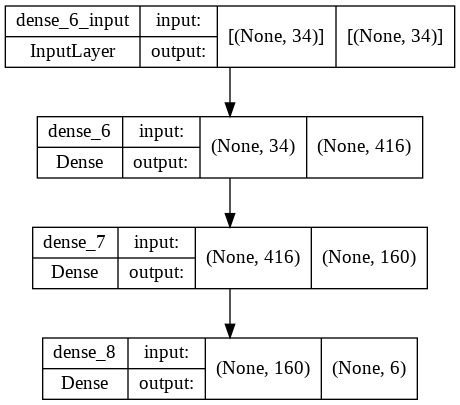

In [ ]:
Image('single_stage_model_1.png')

In [ ]:
keras_y_test = to_categorical(y_test, num_classes=6)

print('Obtained accuracy of {} on the test set'.format(ANNhypermodel.evaluate(X_test, keras_y_test)[1]))

# Retrieve predictions for further analysis
singleStep_ANN_y_pred = np.argmax(ANNhypermodel.predict(X_test), axis=1)

24/24 [==============================] - 0s 2ms/step - loss: 0.4940 - accuracy: 0.8859
Obtained accuracy of 0.8859416246414185 on the test set


#### Performance

Accuracy: 0.8859416445623343
Precision: 0.8956131586281357
F1: 0.8888772235278409
Recall: 0.8859416445623343


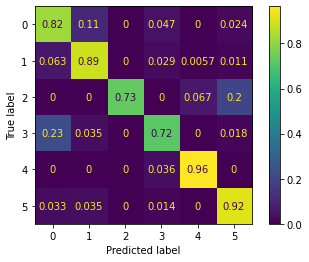

In [ ]:
singleStepANN_accuracy, singleStepANN_precision, singleStepANN_f1, singleStepANN_recall = visualize_perfomance(singleStep_ANN_y_pred, y_test, range(6), "ANN_singleStage_performance")

### Random Forest

Let us run RandomForestClassificator and find the best number of trees: 

GridSearchCV taken 111.41044068336487s to complete
Best Parameters found are {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Obtained accuracy of 0.9124668435013262 on the test set
Accuracy: 0.9124668435013262
Precision: 0.9141053017294046
F1: 0.9125329212151693
Recall: 0.9124668435013262


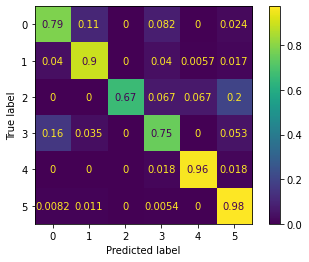

In [ ]:
y_pred_RF, RFmodelSingleStep1 = RandomForestModel(X_train, X_test, y_train, y_test)

singleStepRF_accuracy, singleStepRF_precision, singleStepRF_f1, singleStepRF_recall = visualize_perfomance(y_pred_RF, y_test, range(6), "RF_singleStage_performance")

### KNN

GridSearchCV taken 1.3946657180786133s to complete
Best Parameters found are {'n_neighbors': 1}
Obtained accuracy of 0.8872679045092838 on the test set
Accuracy: 0.8872679045092838
Precision: 0.891208934082227
F1: 0.8884629703974652
Recall: 0.8872679045092838


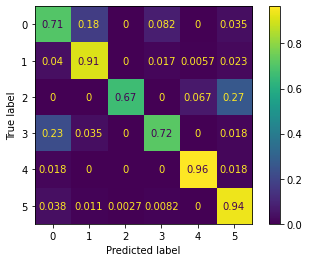

In [ ]:
y_pred_KNN = kNNModel(X_train, X_test, y_train, y_test)
singleStepKNN_accuracy, singleStepKNN_precision, singleStepKNN_f1, singleStepKNN_recall = visualize_perfomance(y_pred_KNN, y_test, range(6), "kNN_singleStage_performance")

### Comparing the three models

<Figure size 432x288 with 0 Axes>

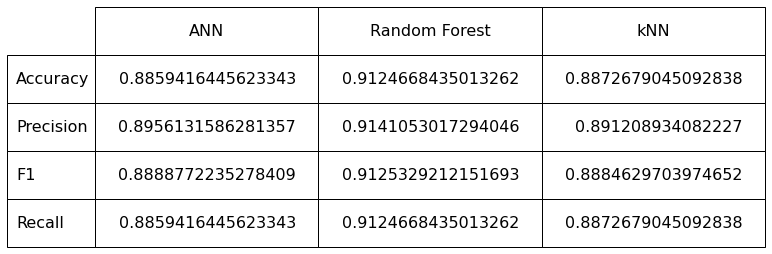

In [ ]:
singleStageANN_metrics = [singleStepANN_accuracy, singleStepANN_precision, singleStepANN_f1, singleStepANN_recall]
singleStageRF_metrics = [singleStepRF_accuracy, singleStepRF_precision, singleStepRF_f1, singleStepRF_recall]
singleStageKNN_metrics = [singleStepKNN_accuracy, singleStepKNN_precision, singleStepKNN_f1, singleStepKNN_recall]

metrics_SingleStage = np.array([singleStageANN_metrics, singleStageRF_metrics, singleStageKNN_metrics])
df_metrics_SingleStage = pd.DataFrame(metrics_SingleStage, 
                                      columns = ['Accuracy', 'Precision', 'F1', 'Recall'],
                                      index = ['ANN', 'Random Forest', 'kNN']).transpose()

plt.figure()
#display(df_metrics_SingleStage)
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


table = ax.table(cellText=df_metrics_SingleStage.values, 
         colLabels=df_metrics_SingleStage.keys(),
         rowLabels=df_metrics_SingleStage.index,
         loc='center')

table.set_fontsize(18)
table.scale(2,4)

#plt.show()
plt.savefig("singleStage_performanceResults.png", bbox_inches="tight" )

#### Selecting the best model for the single stage

In [ ]:
singleStageANN_metrics.append(singleStep_ANN_y_pred)
singleStageRF_metrics.append(y_pred_RF)
singleStageKNN_metrics.append(y_pred_KNN)

singleStageAccuracies = [singleStageANN_metrics[0], singleStageRF_metrics[0], singleStageKNN_metrics[0]]
index_max = max(range(len(singleStageAccuracies)), key=singleStageAccuracies.__getitem__)

singleStageAll = [singleStageANN_metrics, singleStageRF_metrics, singleStageKNN_metrics]
singleStageBestModel = singleStageAll[index_max]

print("In terms of accuracy, the best model is: ")
if(index_max == 0): print("ANN")
elif(index_max == 1): print("Random Forest")
elif(index_max == 2): print("KNN")

In terms of accuracy, the best model is: 
Random Forest


## Double Stage Approach

### Split and Scale

In [ ]:
# DataFrame to numpy arrays, X features and y label column
#X, y = load_dataset(data)

X_train, X_test, y_train, y_test = load_split_scale_dataset(data)

### First Step: Propagation Failures vs Hardware Failures

#### Data Preprocessing

In [ ]:
# Change y_train and y_test labels for first step (binary classification)
# if prop failure (0, 1, 2, 3, 4) -> label = 0.0
# if hw failure (5) -> label = 1.0
first_step_y_train = np.where(y_train != 5.0, np.zeros(y_train.shape[0]), y_train)
first_step_y_test = np.where(y_test != 5.0, np.zeros(y_test.shape[0]), y_test)
first_step_y_train = np.where(y_train == 5.0, np.ones(y_train.shape[0]), first_step_y_train)
first_step_y_test = np.where(y_test == 5.0, np.ones(y_test.shape[0]), first_step_y_test)

In [ ]:
# Check of correctness
print('- y_train -\nShape: {}\n# of HW Failures(5.0): {}\n# of Prop. Failures([0,4]): {}\n'.format(
    y_train.shape, y_train[y_train == 5].shape[0], y_train[y_train < 5.0].shape[0]
    )
)
print('- 1st step y_train -\nShape: {}\n# of HW Failures(1.0): {}\n# of Prop. Failures(0.0): {}\n'.format(
    first_step_y_train.shape,
    first_step_y_train[first_step_y_train == 1.0].shape[0],
    first_step_y_train[first_step_y_train == 0.0].shape[0]
    )
)
print('- y_test -\nShape: {}\n# of HW Failures(5.0): {}\n# of Prop. Failures([0, 4]): {}\n'.format(
    y_test.shape, y_test[y_test == 5.0].shape[0], y_test[y_test < 5.0].shape[0]
    )
)
print('- 1st step y_test -\nShape: {}\n# of HW Failures(1.0): {}\n# of Prop. Failures(0.0): {}\n'.format(
    first_step_y_test.shape,
    first_step_y_test[first_step_y_test == 1.0].shape[0],
    first_step_y_test[first_step_y_test == 0.0].shape[0]
    )
)

- y_train -
Shape: (1759,)
# of HW Failures(5.0): 855
# of Prop. Failures([0,4]): 904

- 1st step y_train -
Shape: (1759,)
# of HW Failures(1.0): 855
# of Prop. Failures(0.0): 904

- y_test -
Shape: (754,)
# of HW Failures(5.0): 367
# of Prop. Failures([0, 4]): 387

- 1st step y_test -
Shape: (754,)
# of HW Failures(1.0): 367
# of Prop. Failures(0.0): 387



#### ANN

In [ ]:
ANNhypermodel_firstStep = binary_ANNmodel(X_train, first_step_y_train, project_name='first_step_double_stage_approach')

Trial 30 Complete [00h 00m 02s]
val_binary_accuracy: 0.9005681872367859

Best val_binary_accuracy So Far: 0.9346590638160706
Total elapsed time: 00h 01m 03s
INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is 352, in the second densely-connected layer is 352 
  and the optimal learning rate for the optimizer is 0.01.
  
Epoch 1/50
44/44 [==============================] - 1s 7ms/step - loss: 0.6820 - binary_accuracy: 0.7242 - val_loss: 0.2971 - val_binary_accuracy: 0.8722
Epoch 2/50
44/44 [==============================] - 0s 5ms/step - loss: 0.3554 - binary_accuracy: 0.8408 - val_loss: 0.3336 - val_binary_accuracy: 0.8722
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 0.3131 - binary_accuracy: 0.8657 - val_loss: 0.2449 - val_binary_accuracy: 0.9034
Epoch 4/50
44/44 [==============================] - 0s 4ms/step - loss: 0.2729 - binary_accuracy: 0.8891 - val_loss: 0

In [ ]:
plot_model(ANNhypermodel_firstStep, to_file='single_step_double_stage_model_1.png', show_shapes=True)

ANNhypermodel_firstStep.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 352)               12320     
                                                                 
 dense_7 (Dense)             (None, 320)               112960    
                                                                 
 dense_8 (Dense)             (None, 2)                 642       
                                                                 
Total params: 125,922
Trainable params: 125,922
Non-trainable params: 0
_________________________________________________________________


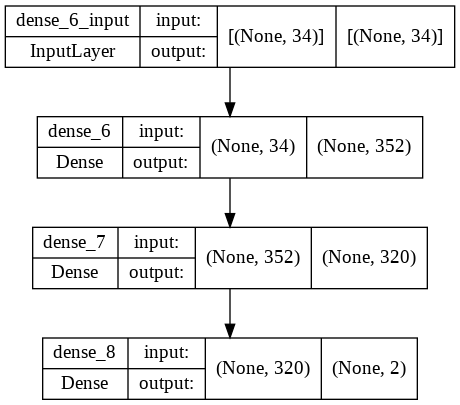

In [ ]:
Image('single_step_double_stage_model_1.png')

In [ ]:
keras_y_test_ANN_firstStep = to_categorical(first_step_y_test, num_classes=2)

print('Obtained accuracy of {} on the test set'.format(ANNhypermodel_firstStep.evaluate(X_test, keras_y_test_ANN_firstStep)[1]))

# Retrieve predictions for further analysis

firstStep_ANN_y_pred = np.argmax(ANNhypermodel_firstStep.predict(X_test), axis=1)

24/24 [==============================] - 0s 3ms/step - loss: 0.2489 - binary_accuracy: 0.9496
Obtained accuracy of 0.9496021270751953 on the test set


Accuracy: 0.9496021220159151
Precision: 0.9500165027579972
F1: 0.9495680197111322
Recall: 0.9496021220159151


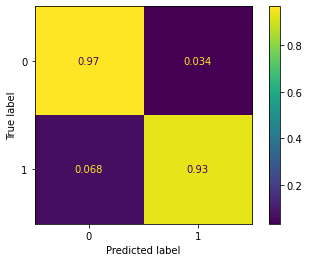

In [ ]:
firstStepANN_accuracy, firstStepANN_precision, firstStepANN_f1, firstStepANN_recall = visualize_perfomance(firstStep_ANN_y_pred, first_step_y_test, range(2), "ANN_firstStep_performance")

In [ ]:
# Replace 1.0 labels substituted only for Keras with 5.0
firstStep_ANN_y_pred = np.where(firstStep_ANN_y_pred == 1.0, 5*np.ones(firstStep_ANN_y_pred.shape[0]), firstStep_ANN_y_pred)

#### Random Forest

GridSearchCV taken 106.58650398254395s to complete
Best Parameters found are {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Obtained accuracy of 0.96684350132626 on the test set
Accuracy: 0.96684350132626
Precision: 0.966988413739245
F1: 0.966832464479257
Recall: 0.96684350132626


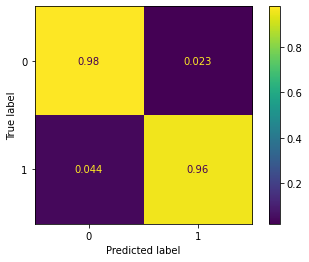

In [ ]:
first_step_y_predRF, RFmodelDoubleStep1 = RandomForestModel(X_train, X_test, first_step_y_train, first_step_y_test)
#y_pred_RF

firstStepRF_accuracy, firstStepRF_precision, firstStepRF_f1, firstStepRF_recall = visualize_perfomance(first_step_y_predRF, first_step_y_test, range(2), "RF_DoubleStage_firstStep_performance")

In [ ]:
print('# of HW Failures predicted: {}'.format(first_step_y_predRF[first_step_y_predRF==5].shape))
print('# of Propagation Failures predicted: {}'.format(first_step_y_predRF[first_step_y_predRF==0].shape))

# of HW Failures predicted: (0,)
# of Propagation Failures predicted: (394,)


#### KNN

GridSearchCV taken 1.4090087413787842s to complete
Best Parameters found are {'n_neighbors': 3}
Obtained accuracy of 0.9509283819628647 on the test set
Accuracy: 0.96684350132626
Precision: 0.966988413739245
F1: 0.966832464479257
Recall: 0.96684350132626


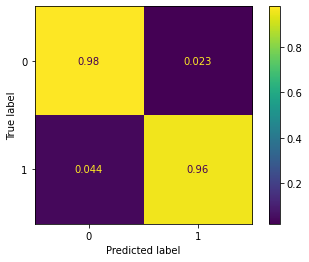

In [ ]:
first_step_y_predKNN = kNNModel(X_train, X_test, first_step_y_train, first_step_y_test)

firstStepKNN_accuracy, firstStepKNN_precision, firstStepKNN_f1, firstStepKNN_recall = visualize_perfomance(first_step_y_predRF, first_step_y_test, range(2), "knn_DoubleStage_firstStep_performance")

#### Comparing the three models

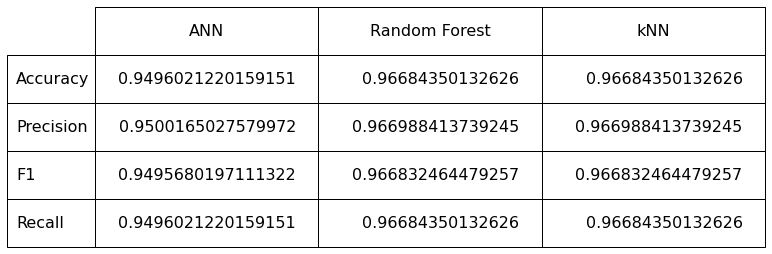

In [ ]:
firstStepANN = [firstStepANN_accuracy, firstStepANN_precision, firstStepANN_f1, firstStepANN_recall]
firstStepRF = [firstStepRF_accuracy, firstStepRF_precision, firstStepRF_f1, firstStepRF_recall]
firstStepKNN = [firstStepKNN_accuracy, firstStepKNN_precision, firstStepKNN_f1, firstStepKNN_recall]

metrics_FirstStep = np.array([firstStepANN, firstStepRF, firstStepKNN])
df_metrics_FirstStep = pd.DataFrame(metrics_FirstStep, 
                                      columns = ['Accuracy', 'Precision', 'F1', 'Recall'],
                                      index = ['ANN', 'Random Forest', 'kNN']).transpose()
#display(df_metrics_SingleStage)
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


table = ax.table(cellText=df_metrics_FirstStep.values, 
         colLabels=df_metrics_FirstStep.keys(),
         rowLabels=df_metrics_FirstStep.index,
         loc='center')

table.set_fontsize(18)
table.scale(2,4)

#plt.show()
plt.savefig("doubleStage_firstStep_performanceResults.png", bbox_inches="tight" )

#### Selecting the best model for the first step

In [ ]:
firstStepANN.append(firstStep_ANN_y_pred)
firstStepRF.append(first_step_y_predRF)
firstStepKNN.append(first_step_y_predKNN)

firstStepAccuracies = [firstStepANN[0], firstStepRF[0], firstStepKNN[0]]
index_max = max(range(len(firstStepAccuracies)), key=firstStepAccuracies.__getitem__)

firstStepAll = [firstStepANN, firstStepRF, firstStepKNN]
firstStepBestModel = firstStepAll[index_max]
first_step_y_pred = np.copy(firstStepBestModel[-1])

print("In terms of accuracy, the best model is: ")
if(index_max == 0): print("ANN")
elif(index_max == 1): print("Random Forest")
elif(index_max == 2): print("KNN")

In terms of accuracy, the best model is: 
Random Forest


### Second Step: Propagation Failure Classification

As train set consider rows of the training set with 'label' values in [0, 4] <br>
As test set consider only rows predicted as 0.0 in the first step

#### Data Preprocessing

In [ ]:
# Train set
train_mask = y_train != 5
second_step_X_train = np.copy(X_train[train_mask])
second_step_y_train = np.copy(y_train[train_mask])
# Test set
test_mask = first_step_y_pred != 1
second_step_X_test = np.copy(X_test[test_mask])
second_step_y_test = np.copy(y_test[test_mask])

In [ ]:
# Check of correctness
print('- y_train -\nShape: {}\n# of HW Failures: {}\n# of Prop. Failures: {}\n'.format(
    y_train.shape, y_train[y_train == 5.0].shape[0], y_train[y_train < 5.0].shape[0]
    )
)
print('- 2nd step X_train -\nShape: {}\n'.format(
    second_step_X_train.shape
    )
)

print('- 2nd step y_train -\nShape: {}\n'.format(
    second_step_y_train.shape
    )
)
print('- 1st step y_pred -\nShape: {}\n# of HW Failures: {}\n# of Prop. Failures: {}\n'.format(
    first_step_y_pred.shape,
    first_step_y_pred[first_step_y_pred == 5.0].shape[0],
    first_step_y_pred[first_step_y_pred == 0.0].shape[0]
    )
)
print('- 2nd step X_test -\nShape: {}\n'.format(
    second_step_X_test.shape,
    )
)
print('- 2nd step y_test -\nShape: {}\n'.format(
    second_step_y_test.shape,
    )
)

- y_train -
Shape: (1759,)
# of HW Failures: 855
# of Prop. Failures: 904

- 2nd step X_train -
Shape: (904, 34)

- 2nd step y_train -
Shape: (904,)

- 1st step y_pred -
Shape: (754,)
# of HW Failures: 0
# of Prop. Failures: 394

- 2nd step X_test -
Shape: (394, 34)

- 2nd step y_test -
Shape: (394,)



#### ANN

In [ ]:
ANNhypermodel_secondStep = multiclass_ANNmodel(second_step_X_train, second_step_y_train, nb_classes=5, project_name='second_step_double_stage_approach')

# for the HW predicted as Prop in 1st step, distribute them randomly in the 5 classes
keras_second_step_y_testANN = np.where(second_step_y_test==5, np.random.randint(low=0.0, high=4.0, size=second_step_y_test.shape), second_step_y_test)

keras_second_step_y_testANN = to_categorical(keras_second_step_y_testANN, num_classes=5)

print('Obtained accuracy of {} on the test set'.format(ANNhypermodel_secondStep.evaluate(second_step_X_test, keras_second_step_y_testANN)[1]))

# Retrieve predictions for further analysis
second_step_y_predANN = np.argmax(ANNhypermodel_secondStep.predict(second_step_X_test), axis=1)

Trial 30 Complete [00h 00m 02s]
val_accuracy: 0.9060773253440857

Best val_accuracy So Far: 0.9060773253440857
Total elapsed time: 00h 00m 51s
INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is 192, in the second densely-connected layer is 192 
  and the optimal learning rate for the optimizer is 0.01.
  
Epoch 1/50
23/23 [==============================] - 1s 10ms/step - loss: 1.2573 - accuracy: 0.4993 - val_loss: 0.7617 - val_accuracy: 0.7348
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 0.7240 - accuracy: 0.7012 - val_loss: 0.5127 - val_accuracy: 0.7901
Epoch 3/50
23/23 [==============================] - 0s 4ms/step - loss: 0.5470 - accuracy: 0.7732 - val_loss: 0.4493 - val_accuracy: 0.8122
Epoch 4/50
23/23 [==============================] - 0s 4ms/step - loss: 0.4768 - accuracy: 0.8022 - val_loss: 0.4145 - val_accuracy: 0.8508
Epoch 5/50
23/23 [===============

In [ ]:
for i in range(6):
  print('# of label{} predicted: {}'.format(i, second_step_y_predANN[second_step_y_predANN==i].shape))

# of label0 predicted: (89,)
# of label1 predicted: (169,)
# of label2 predicted: (13,)
# of label3 predicted: (65,)
# of label4 predicted: (58,)
# of label5 predicted: (0,)


In [ ]:
plot_model(ANNhypermodel_secondStep, to_file='double_stage_model_2.png', show_shapes=True)

ANNhypermodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 416)               14560     
                                                                 
 dense_7 (Dense)             (None, 160)               66720     
                                                                 
 dense_8 (Dense)             (None, 6)                 966       
                                                                 
Total params: 82,246
Trainable params: 82,246
Non-trainable params: 0
_________________________________________________________________


Accuracy: 0.817258883248731
Precision: 0.7902581371813245
F1: 0.8026484688149926
Recall: 0.817258883248731


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


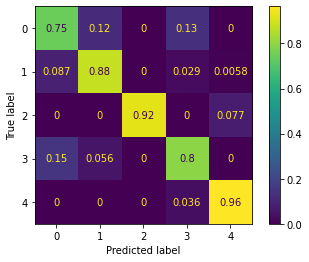

In [ ]:
secondStepANN_accuracy, secondStepANN_precision, secondStepANN_f1, secondStepANN_recall = visualize_perfomance(second_step_y_predANN, second_step_y_test, range(5), "ANN_secondStep_performance")

#### Random Forest

GridSearchCV taken 84.44704222679138s to complete
Best Parameters found are {'bootstrap': False, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Obtained accuracy of 0.8451776649746193 on the test set
Accuracy: 0.8451776649746193
Precision: 0.8148313153295548
F1: 0.8288044933360575
Recall: 0.8451776649746193


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


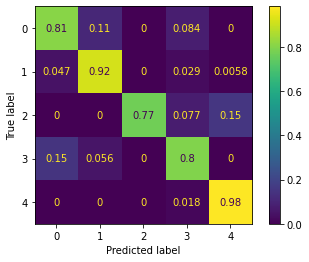

In [ ]:
second_step_y_predRF, RFmodelDoubleStep2 = RandomForestModel(second_step_X_train, second_step_X_test, second_step_y_train, second_step_y_test)

secondStepRF_accuracy, secondStepRF_precision, secondStepRF_f1, secondStepRF_recall = visualize_perfomance(second_step_y_predRF, second_step_y_test, range(5), "RF_DoubleStage_secondStep_performance")

In [ ]:
print('# of HW Failures predicted: {}'.format(second_step_y_predRF[second_step_y_predRF==5].shape))
print('# of Propagation Failures predicted: {}'.format(second_step_y_predRF[second_step_y_predRF==0].shape))

# of HW Failures predicted: (0,)
# of Propagation Failures predicted: (89,)


#### KNN

GridSearchCV taken 0.6688148975372314s to complete
Best Parameters found are {'n_neighbors': 1}
Obtained accuracy of 0.8299492385786802 on the test set
Accuracy: 0.8299492385786802
Precision: 0.7956876945496599
F1: 0.8122948196061951
Recall: 0.8299492385786802


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


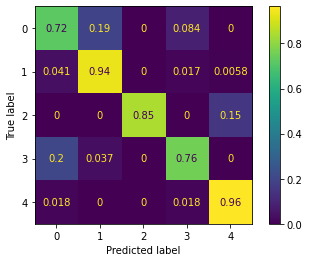

In [ ]:
second_step_y_predKNN = kNNModel(second_step_X_train, second_step_X_test, second_step_y_train, second_step_y_test)

secondStepKNN_accuracy, secondStepKNN_precision, secondStepKNN_f1, secondStepKNN_recall = visualize_perfomance(second_step_y_predKNN, second_step_y_test, range(5), "kNN_DoubleStage_secondStep_performance")

#### Comparing the three models

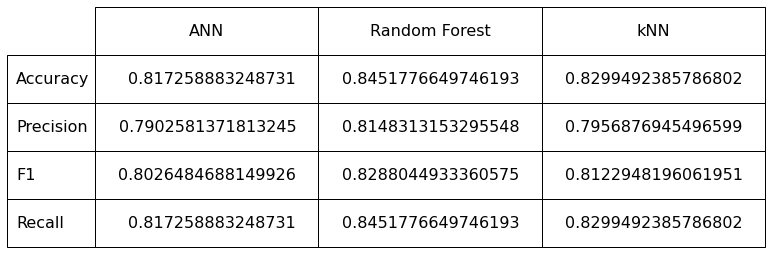

In [ ]:
secondStepANN = [secondStepANN_accuracy, secondStepANN_precision, secondStepANN_f1, secondStepANN_recall]
secondStepRF = [secondStepRF_accuracy, secondStepRF_precision, secondStepRF_f1, secondStepRF_recall]
secondStepKNN = [secondStepKNN_accuracy, secondStepKNN_precision, secondStepKNN_f1, secondStepKNN_recall]

metrics_SecondStep = np.array([secondStepANN, secondStepRF, secondStepKNN])
df_metrics_SecondStep = pd.DataFrame(metrics_SecondStep, 
                                      columns = ['Accuracy', 'Precision', 'F1', 'Recall'],
                                      index = ['ANN', 'Random Forest', 'kNN']).transpose()
#display(df_metrics_SingleStage)
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


table = ax.table(cellText=df_metrics_SecondStep.values, 
         colLabels=df_metrics_SecondStep.keys(),
         rowLabels=df_metrics_SecondStep.index,
         loc='center')

table.set_fontsize(18)
table.scale(2,4)

#plt.show()
plt.savefig("DoubleStep_secondStep_performanceResults.png", bbox_inches="tight" )

#### Selecting the best model for the second step

In [ ]:
secondStepANN.append(second_step_y_predANN)
secondStepRF.append(second_step_y_predRF)
secondStepKNN.append(second_step_y_predKNN)

secondStepAccuracies = [secondStepANN[0], secondStepRF[0], secondStepKNN[0]]
index_max = max(range(len(secondStepAccuracies)), key=secondStepAccuracies.__getitem__)

secondStepAll = [secondStepANN, secondStepRF, secondStepKNN]
secondStepBestModel = secondStepAll[index_max]
second_step_y_pred = secondStepBestModel[-1]

print("In terms of accuracy, the best model is: ")
if(index_max == 0): print("ANN")
elif(index_max == 1): print("Random Forest")
elif(index_max == 2): print("KNN")

In terms of accuracy, the best model is: 
Random Forest


### Merge the two steps results and Performance Analysis

In [ ]:
first_step_y_pred = np.where(first_step_y_pred == 1.0, 5*np.ones(first_step_y_pred.shape[0]), first_step_y_pred)
# Get the indices of the elements of y_test predicted as Propagation Failures in the first step
idx_prop_fail = np.where(first_step_y_pred == 0.0)[0]

# y_pred made as first_step_y_pred but where rows predicted as 0 in the 1st step are replaced with labels predicted in the 2nd step
y_pred = np.copy(first_step_y_pred)
np.put(y_pred, idx_prop_fail, second_step_y_pred)

print(first_step_y_pred.shape)
print(y_test.shape)
print(y_pred.shape)

(754,)
(754,)
(754,)


Accuracy: 0.9071618037135278
Precision: 0.910205072415713
F1: 0.907817348395826
Recall: 0.9071618037135278


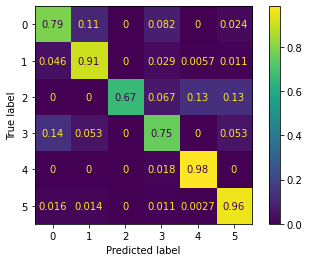

In [ ]:
DoubleStage_accuracy, DoubleStage_precision, DoubleStage_f1, DoubleStage_recall = visualize_perfomance(y_pred, y_test, range(6), "DoubleStage_overall_performance")

# Comparing the two approaches' metrics


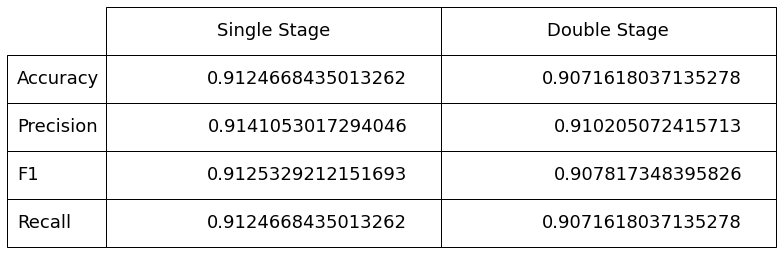

In [ ]:
SingleStageMetrics = singleStageBestModel[:-1] #deleting the y_pred
DoubleStageMetrics = np.array([DoubleStage_accuracy, DoubleStage_precision, DoubleStage_f1, DoubleStage_recall])

df_metrics_SingleStage = pd.DataFrame(SingleStageMetrics, 
                                      columns = ['Single Stage'],
                                      index = ['Accuracy', 'Precision', 'F1', 'Recall'])
df_metrics_DoubleStage = pd.DataFrame(DoubleStageMetrics, 
                                      columns = ['Double Stage'],
                                      index = ['Accuracy', 'Precision', 'F1', 'Recall'])

df_metrics_Total = pd.merge(df_metrics_SingleStage, df_metrics_DoubleStage, left_index=True, right_index=True)

#display(df_metrics_SingleStage)
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


table = ax.table(cellText=df_metrics_Total.values, 
         colLabels=df_metrics_Total.keys(),
         rowLabels=df_metrics_Total.index,
         loc='center')

table.set_fontsize(18)
table.scale(2,4)

#plt.show()
plt.savefig("two_approaches_performanceResults.png", bbox_inches="tight" )

# Feature Reduction (consider a subset of windows)

We will use only the better performing model to evaluate the effects of feature reduction

In [ ]:
N_0_cols = ['esN', 'sesN', 'txMaxAN', 'txminAN', 'rxmaxAN', 'rxminAN', 'txMaxBN', 'txminBN', 'rxmaxBN', 'rxminBN']

In [ ]:
N_1_cols = ['esN-1', 'sesN-1', 'txMaxAN-1', 'txminAN-1', 'rxmaxAN-1', 'rxminAN-1', 'txMaxBN-1', 'txminBN-1', 'rxmaxBN-1', 'rxminBN-1']

In [ ]:
N_2_cols = ['esN-2', 'sesN-2', 'txMaxAN-2', 'txminAN-2', 'rxmaxAN-2', 'rxminAN-2', 'txMaxBN-2', 'txminBN-2', 'rxmaxBN-2', 'rxminBN-2']

In [ ]:
def given_dataset_estimator_get_score(dataset, cols_to_drop, estimator, imageName):
  '''
  Given the dataset, the columns to drop, the estimator,
  it return the score of the asked estimator with a predefined list of metrics
  (accuracy, precision, f1, recall)
  '''
  # Column drop
  new_data = data.drop(columns = cols_to_drop).copy()
  print('The columns of the new dataset are: {}'.format(list(new_data.columns)))

  # Load, Split and Scale the dataset
  X_train, X_test, y_train, y_test = load_split_scale_dataset(new_data)

  y_pred = estimator(X_train, X_test, y_train, y_test)[0]
  accuracy, precision, f1, recall = visualize_perfomance(y_pred, y_test, range(6), imageName)

  return accuracy, precision, f1, recall


## N-2

The columns of the new dataset are: ['esN-2', 'sesN-2', 'txMaxAN-2', 'txminAN-2', 'rxmaxAN-2', 'rxminAN-2', 'txMaxBN-2', 'txminBN-2', 'rxmaxBN-2', 'rxminBN-2', 'lowthr', 'ptx', 'RxNominal', 'Thr_min', 'label']
GridSearchCV taken 95.76260328292847s to complete
Best Parameters found are {'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Obtained accuracy of 0.9045092838196287 on the test set
Accuracy: 0.9045092838196287
Precision: 0.9071116336366422
F1: 0.905055673745964
Recall: 0.9045092838196287


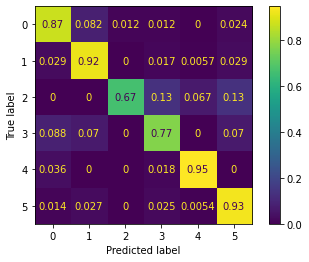

In [ ]:
cols_to_drop = N_1_cols + N_0_cols
N_2_accuracy, N_2_precision, N_2_f1, N_2_recall = given_dataset_estimator_get_score(data, cols_to_drop, RandomForestModel,"N-2")

## N -1

The columns of the new dataset are: ['esN-1', 'sesN-1', 'txMaxAN-1', 'txminAN-1', 'rxmaxAN-1', 'rxminAN-1', 'txMaxBN-1', 'txminBN-1', 'rxmaxBN-1', 'rxminBN-1', 'lowthr', 'ptx', 'RxNominal', 'Thr_min', 'label']
GridSearchCV taken 89.25537753105164s to complete
Best Parameters found are {'bootstrap': False, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Obtained accuracy of 0.889920424403183 on the test set
Accuracy: 0.889920424403183
Precision: 0.8875761223623739
F1: 0.8884056043799821
Recall: 0.889920424403183


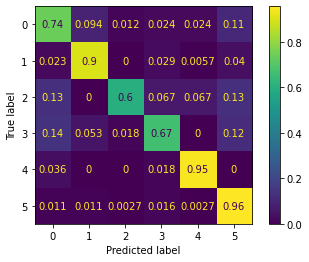

In [ ]:
cols_to_drop = N_0_cols + N_2_cols
N_1_accuracy, N_1_precision, N_1_f1, N_1_recall = given_dataset_estimator_get_score(data, cols_to_drop, RandomForestModel, "N-1")

## N

The columns of the new dataset are: ['esN', 'sesN', 'txMaxAN', 'txminAN', 'rxmaxAN', 'rxminAN', 'txMaxBN', 'txminBN', 'rxmaxBN', 'rxminBN', 'lowthr', 'ptx', 'RxNominal', 'Thr_min', 'label']
GridSearchCV taken 114.31502842903137s to complete
Best Parameters found are {'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Obtained accuracy of 0.916445623342175 on the test set
Accuracy: 0.916445623342175
Precision: 0.9168417358830638
F1: 0.9162888572958748
Recall: 0.916445623342175


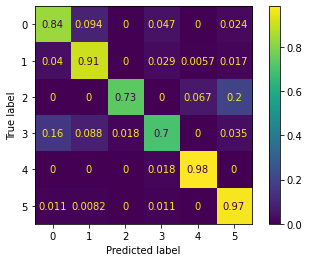

In [ ]:
cols_to_drop = N_2_cols + N_1_cols

N_0_accuracy, N_0_precision, N_0_f1, N_0_recall  = given_dataset_estimator_get_score(data, cols_to_drop, RandomForestModel, "N")

## N-2 and N-1

The columns of the new dataset are: ['esN-2', 'sesN-2', 'txMaxAN-2', 'txminAN-2', 'rxmaxAN-2', 'rxminAN-2', 'txMaxBN-2', 'txminBN-2', 'rxmaxBN-2', 'rxminBN-2', 'esN-1', 'sesN-1', 'txMaxAN-1', 'txminAN-1', 'rxmaxAN-1', 'rxminAN-1', 'txMaxBN-1', 'txminBN-1', 'rxmaxBN-1', 'rxminBN-1', 'lowthr', 'ptx', 'RxNominal', 'Thr_min', 'label']
GridSearchCV taken 102.80872702598572s to complete
Best Parameters found are {'bootstrap': False, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Obtained accuracy of 0.8846153846153846 on the test set
Accuracy: 0.8846153846153846
Precision: 0.8827924830845834
F1: 0.8833488016191019
Recall: 0.8846153846153846


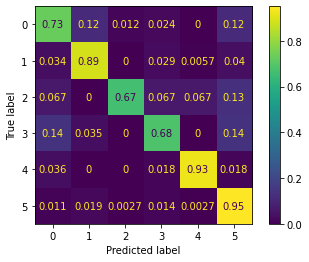

In [ ]:
cols_to_drop = N_0_cols
N_21_accuracy, N_21_precision, N_21_f1, N_21_recall  = given_dataset_estimator_get_score(data, cols_to_drop, RandomForestModel, "N-1_N-2")

## N and N-1

The columns of the new dataset are: ['esN-1', 'sesN-1', 'txMaxAN-1', 'txminAN-1', 'rxmaxAN-1', 'rxminAN-1', 'txMaxBN-1', 'txminBN-1', 'rxmaxBN-1', 'rxminBN-1', 'esN', 'sesN', 'txMaxAN', 'txminAN', 'rxmaxAN', 'rxminAN', 'txMaxBN', 'txminBN', 'rxmaxBN', 'rxminBN', 'lowthr', 'ptx', 'RxNominal', 'Thr_min', 'label']
GridSearchCV taken 101.88623356819153s to complete
Best Parameters found are {'bootstrap': False, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Obtained accuracy of 0.9190981432360743 on the test set
Accuracy: 0.9190981432360743
Precision: 0.9204288371242384
F1: 0.9192816598889411
Recall: 0.9190981432360743


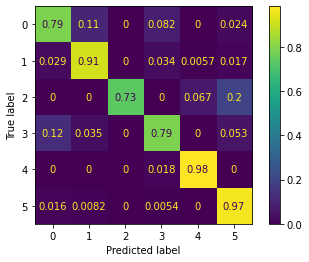

In [ ]:
cols_to_drop = N_2_cols
N_10_accuracy, N_10_precision, N_10_f1, N_10_recall  = given_dataset_estimator_get_score(data, cols_to_drop, RandomForestModel, "N_N-1")

## Perfomance Comparison

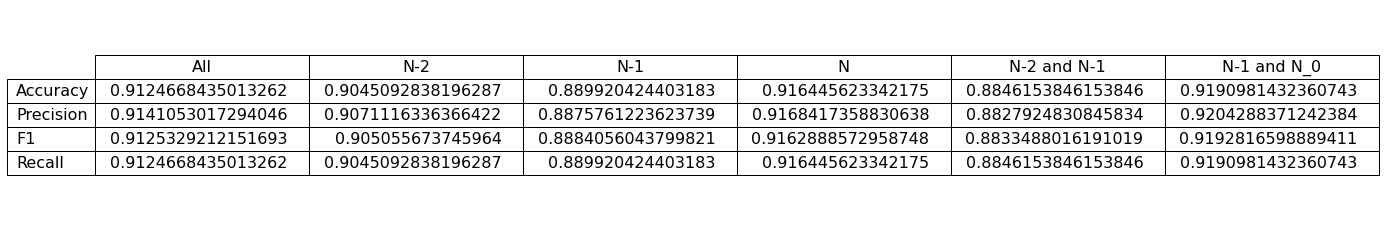

In [ ]:
N_2 = [N_2_accuracy, N_2_precision, N_2_f1, N_2_recall]
N_1 = [N_1_accuracy, N_1_precision, N_1_f1, N_1_recall]
N_0 = [N_0_accuracy, N_0_precision, N_0_f1, N_0_recall]
N_21 = [N_21_accuracy, N_21_precision, N_21_f1, N_21_recall]
N_10 = [N_10_accuracy, N_10_precision, N_10_f1, N_10_recall]

singleStageRF_metricsNew = [singleStepRF_accuracy, singleStepRF_precision, singleStepRF_f1, singleStepRF_recall]
# singleStageRF_metrics comes from Single Stage Random Forest Classifier section

metrics_windows_reduction = np.array([singleStageRF_metricsNew, N_2, N_1, N_0, N_21, N_10])
df_metrics_windows_reduction = pd.DataFrame(metrics_windows_reduction, 
                                      columns = ['Accuracy', 'Precision', 'F1', 'Recall'],
                                      index = ['All', 'N-2', 'N-1', 'N', 'N-2 and N-1', 'N-1 and N_0']).transpose()
#display(df_metrics_SingleStage)
fig, ax = plt.subplots(figsize=(20,4))

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


table = ax.table(cellText=df_metrics_windows_reduction.values, 
         colLabels=df_metrics_windows_reduction.keys(),
         rowLabels=df_metrics_windows_reduction.index,
         loc='center')

table.set_fontsize(18)
table.scale(1.15,2)

#plt.show()

plt.savefig('windows_reduction.png')

# Transfer Learning with eqtype

https://www.tensorflow.org/guide/keras/transfer_learning

## Data Loading and Preprocessing

In [ ]:
# Relaod the data but keep 'eqtype' column 
raw_data = pd.read_csv('Labelled_Multiclass.csv')
columns = raw_data.columns.to_numpy()
transfer_data = raw_data.drop(columns=columns[:4])
transfer_data

transfer_data.drop(columns=['acmLowerMode', 'bandwidth', 'acmEngine', 'freqband'], inplace=True)

# replace NaN with median
nanindexes=np.where(pd.isnull(transfer_data))

for i in np.unique(nanindexes[1]):
    tempdata = transfer_data.iloc[:,i] #i-th column having at least one value with nan
    median = tempdata.median(skipna=True) #calculating the median of that column excluding the nan
    transfer_data[transfer_data.columns.values[i]] = transfer_data[transfer_data.columns.values[i]].fillna(median) #insert the median in the dataset



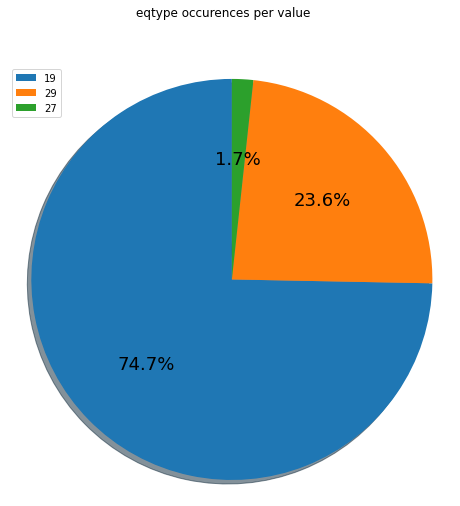

In [ ]:
eqtype_occurences = transfer_data['eqtype'].value_counts()

fig, ax = plt.subplots(figsize=(8,8))

fig.suptitle('eqtype occurences per value')

ax.pie(eqtype_occurences.values, labels=None, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 18})

ax.axis('equal')
ax.legend(eqtype_occurences.index)
#plt.show()
plt.savefig("eqType_transferLearning.png")

We can train an initial model based only on the rows with eqtype=19 and apply it to the rows with eqtype=29 and eventually fine tuning it.

## Dataset split

In [ ]:
# Split the dataset in rows with eqtype=19 and rows with eqtype=29 (ignore eqtype=27)
pre_trained_data = transfer_data[transfer_data['eqtype'] == 19]

pre_X_train, pre_X_test, pre_y_train, pre_y_test = load_split_scale_dataset(pre_trained_data)

pre_keras_y_train = to_categorical(pre_y_train, num_classes=6)
pre_keras_y_test = to_categorical(pre_y_test, num_classes=6)


other_data = transfer_data[transfer_data['eqtype'] == 29]

X_train, X_test, y_train, y_test = load_split_scale_dataset(other_data)
keras_y_train = to_categorical(y_train, num_classes=6)
keras_y_test = to_categorical(y_test, num_classes=6)

## Build the pretrained model

In [ ]:

pretrained_model = multiclass_ANNmodel(pre_X_train, pre_y_train, nb_classes=6, project_name='pretrained_model')

pre_keras_y_test = to_categorical(pre_y_test, num_classes=6)

print('The pretrained model has an accuracy of {} on the test set with eqtype=19'.format(pretrained_model.evaluate(pre_X_test, pre_keras_y_test)[1]))

Trial 30 Complete [00h 00m 03s]
val_accuracy: 0.6996197700500488

Best val_accuracy So Far: 0.8060836791992188
Total elapsed time: 00h 00m 58s
INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is 384, in the second densely-connected layer is 384 
  and the optimal learning rate for the optimizer is 0.01.
  
Epoch 1/50
33/33 [==============================] - 1s 8ms/step - loss: 1.4056 - accuracy: 0.4448 - val_loss: 1.1357 - val_accuracy: 0.5665
Epoch 2/50
33/33 [==============================] - 0s 4ms/step - loss: 0.9491 - accuracy: 0.6495 - val_loss: 0.8604 - val_accuracy: 0.6806
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 0.7229 - accuracy: 0.7343 - val_loss: 0.7169 - val_accuracy: 0.7072
Epoch 4/50
33/33 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.7695 - val_loss: 0.7070 - val_accuracy: 0.7452
Epoch 5/50
33/33 [================

In [ ]:
# Evaluate perfomance on the other datset (eqtype) using the pretrained model
print('The pretrained model has an accuracy of {} on the test set with eqtype=29'.format(pretrained_model.evaluate(X_test, keras_y_test)[1]))

6/6 [==============================] - 0s 3ms/step - loss: 2.4714 - accuracy: 0.4438
The pretrained model has an accuracy of 0.4438202381134033 on the test set with eqtype=29


## Create a new model on top of the output of one (or several) layers from the base model.

In [ ]:
pretrained_model.trainable = False
inputs = Input(shape=(35))
# The pretrained_model is running in inference mode here,
# by passing `training=False`.
x = pretrained_model(inputs, training=False)
outputs = Dense(6)(x)
model = Model(inputs, outputs)

stop_early = EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Fit the new model with the eqtype=19 dataset

In [ ]:
model.fit(X_train, keras_y_train, epochs=20, callbacks=[stop_early], validation_split=0.2)
print('The pretrained model has an accuracy of {} on the test set with eqtype=29'.format(model.evaluate(X_test, keras_y_test)[1]))

Epoch 1/20
11/11 [==============================] - 1s 23ms/step - loss: 1.5997 - accuracy: 0.2169 - val_loss: 1.5463 - val_accuracy: 0.3012
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 1.5697 - accuracy: 0.2229 - val_loss: 1.5161 - val_accuracy: 0.3253
Epoch 3/20
11/11 [==============================] - 0s 6ms/step - loss: 1.5403 - accuracy: 0.2590 - val_loss: 1.4865 - val_accuracy: 0.3373
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 1.5112 - accuracy: 0.3494 - val_loss: 1.4573 - val_accuracy: 0.6024
Epoch 5/20
11/11 [==============================] - 0s 6ms/step - loss: 1.4824 - accuracy: 0.6295 - val_loss: 1.4285 - val_accuracy: 0.7108
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 1.4542 - accuracy: 0.7078 - val_loss: 1.4001 - val_accuracy: 0.8554
Epoch 7/20
11/11 [==============================] - 0s 6ms/step - loss: 1.4265 - accuracy: 0.8554 - val_loss: 1.3721 - val_accuracy: 0.9277
Epoch 8/20
11/11 [=

### Fine-tuning

In [ ]:
# Unfreeze the base model
pretrained_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=Adam(1e-5),  # Very low learning rate
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(X_train, keras_y_train, epochs=50, callbacks=[stop_early], validation_split=0.2)

Epoch 1/50
11/11 [==============================] - 1s 24ms/step - loss: 1.0964 - accuracy: 0.8976 - val_loss: 1.0546 - val_accuracy: 0.9157
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 1.0959 - accuracy: 0.8976 - val_loss: 1.0542 - val_accuracy: 0.9157
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 1.0954 - accuracy: 0.8976 - val_loss: 1.0537 - val_accuracy: 0.9157
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 1.0950 - accuracy: 0.8976 - val_loss: 1.0533 - val_accuracy: 0.9157
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 1.0945 - accuracy: 0.8976 - val_loss: 1.0529 - val_accuracy: 0.9157
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 1.0941 - accuracy: 0.8976 - val_loss: 1.0525 - val_accuracy: 0.9157
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 1.0936 - accuracy: 0.8976 - val_loss: 1.0521 - val_accuracy: 0.9157
Epoch 8/50
11/11 [=

In [ ]:
print('The pretrained model has an accuracy of {} on the test set with eqtype=29'.format(model.evaluate(X_test, keras_y_test)[1]))

6/6 [==============================] - 0s 3ms/step - loss: 1.0699 - accuracy: 0.8989
The pretrained model has an accuracy of 0.898876428604126 on the test set with eqtype=29


# SMOTE (Synthetic Minority Oversampling)

### Dataset Load

In [ ]:
# load, split and scale the data from preprocessed dataset (main workflow)
X_train, X_test, y_train, y_test = load_split_scale_dataset(data)

## Original dataset

In [ ]:
print('Original train rows: {}'.format(y_train.shape[0]))

Original train rows: 1759


Nb of occurences [199 407  34 133 131 855]


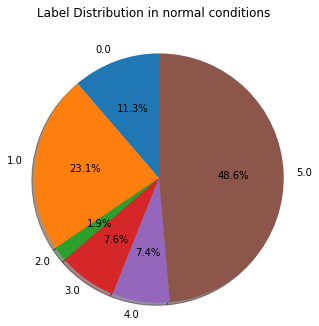

In [ ]:
# Label distribution
values, counts = np.unique(y_train, return_counts=True)

fig, ax = plt.subplots(figsize=(5,5))

fig.suptitle('Label Distribution in normal conditions')
_ = ax.pie(counts, labels=values, autopct='%1.1f%%',
        shadow=True, startangle=90)
_ = ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print('Nb of occurences {}'.format(counts))

Performance metrics in single stage apporach without SMOTE:
	- Accuracy 0.9124668435013262
	- Precision 0.9141053017294046
	- F1-score 0.9125329212151693
	- Recall 0.9124668435013262


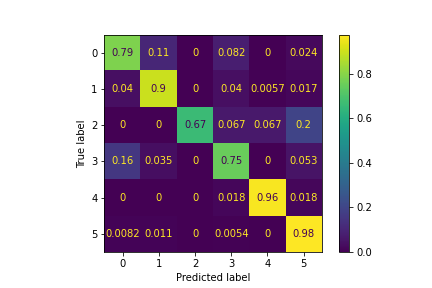

In [ ]:
# Retrieve metrics obtained in single stage approach to compare 
print('Performance metrics in single stage apporach without SMOTE:\n'
'\t- Accuracy {}\n'
'\t- Precision {}\n'
'\t- F1-score {}\n'
'\t- Recall {}'.format(singleStepRF_accuracy, singleStepRF_precision, singleStepRF_f1, singleStepRF_recall))

Image('RF_singleStage_performance.png')

### Oversample Data

In [ ]:
# transform the dataset
# create synthetic samples such that the occurences of labels are at least
nb_samples_per_class = {0.0: 200, 2.0: 200, 3.0: 200, 4.0: 200}

oversample = SMOTE(sampling_strategy=nb_samples_per_class)
over_X_train, over_y_train = oversample.fit_resample(X_train, y_train)

fig.suptitle('Label Distribution after SMOTE')

print('Train rows after oversampling: {}'.format(over_y_train.shape[0]))

Train rows after oversampling: 2062


Nb of occurences [200 407 200 200 200 855]


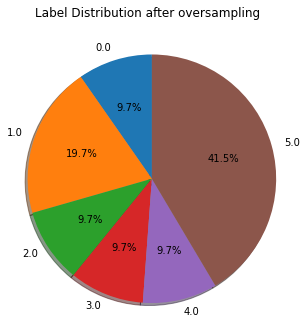

In [ ]:
values, counts = np.unique(over_y_train, return_counts=True)

fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Label Distribution after oversampling')
_ = ax.pie(counts, labels=values, autopct='%1.1f%%',
        shadow=True, startangle=90)
_ = ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
print('Nb of occurences {}'.format(counts))

GridSearchCV taken 144.99450421333313s to complete
Best Parameters found are {'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Obtained accuracy of 0.9190981432360743 on the test set
Accuracy: 0.9190981432360743
Precision: 0.9210461752049679
F1: 0.9195571345868305
Recall: 0.9190981432360743


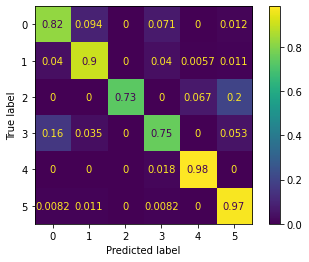

In [ ]:
# Create the model
over_y_pred_RF = RandomForestModel(over_X_train, X_test, over_y_train, y_test)[0]
# Performance Evaluation
over_singleStepRF_accuracy, over_singleStepRF_precision, over_singleStepRF_f1, over_singleStepRF_recall = visualize_perfomance(over_y_pred_RF, y_test, range(6), "oversampled_RF_singleStage_performance")

### Oversample and Undersample Data

In [ ]:
# Let's see if perfomance increases by undersampling the majority class then oversampling minorities

# Undersampling
# Since in the original data the labels 2 and 3 are easily confused with label 0
# and label 5 classes, slightly decrease them
nb_sample_of_majority = {1.0: 350, 5.0: 650}
undersample = RandomUnderSampler(sampling_strategy=nb_sample_of_majority)
under_X_train, under_y_train = undersample.fit_resample(X_train, y_train)
print('Train rows after undersampling: {}'.format(under_y_train.shape[0]))

Train rows after undersampling: 1497


Nb of occurences [199 350  34 133 131 650]


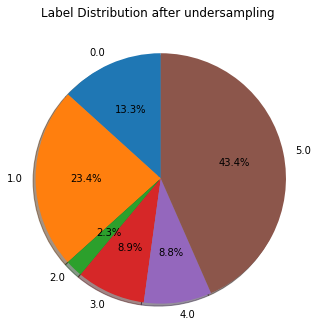

In [ ]:
values, counts = np.unique(under_y_train, return_counts=True)

fig, ax = plt.subplots(figsize=(5,5))

fig.suptitle('Label Distribution after undersampling')

_ = ax.pie(counts, labels=values, autopct='%1.1f%%',
        shadow=True, startangle=90)
_ = ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print('Nb of occurences {}'.format(counts))

In [ ]:
# Oversampling
# Slightly increase the samples of 2.0 such to have a more balanced set
nb_samples_per_class = {2.0: 100}
oversample = SMOTE(sampling_strategy=nb_samples_per_class)
over_under_X_train, over_under_y_train = oversample.fit_resample(under_X_train, under_y_train)

print('Train rows after oversampling + undersampling: {}'.format(over_under_y_train.shape[0]))

Train rows after oversampling + undersampling: 1563


Nb of occurences [199 350 100 133 131 650]


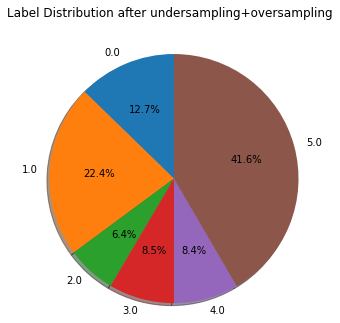

In [ ]:
values, counts = np.unique(over_under_y_train, return_counts=True)

fig, ax = plt.subplots(figsize=(5,5))

fig.suptitle('Label Distribution after undersampling+oversampling')

_ = ax.pie(counts, labels=values, autopct='%1.1f%%',
        shadow=True, startangle=90)
_ = ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print('Nb of occurences {}'.format(counts))

GridSearchCV taken 112.13233590126038s to complete
Best Parameters found are {'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Obtained accuracy of 0.9230769230769231 on the test set
Accuracy: 0.9230769230769231
Precision: 0.9257961412569048
F1: 0.923825652277877
Recall: 0.9230769230769231


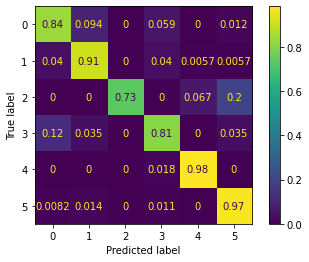

In [ ]:
# Create the model
over_under_y_pred_RF = RandomForestModel(over_under_X_train, X_test, over_under_y_train, y_test)[0]
# Performance Evaluation
over_under_singleStepRF_accuracy, over_under_singleStepRF_precision, over_under_singleStepRF_f1, over_under_singleStepRF_recall = visualize_perfomance(over_under_y_pred_RF, y_test, range(6), "over_under_sampled_RF_singleStage_performance")